# imports 

In [1]:
import os
import awscli as aws
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date 
from datetime import time
import math

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely import geometry

import matplotlib.pyplot as plt
import xarray 
import metpy  
from mpl_toolkits.basemap import Basemap
import colormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import time
import calendar
from matplotlib.patches import Polygon
from netCDF4 import Dataset # Import the NetCDF Python interface
import netCDF4 as nc
import dask
import nco
from sklearn.neighbors import NearestNeighbors
from math import radians, cos, sin, asin, sqrt
from textwrap import wrap
import matplotlib.patches as mpatches
import matplotlib.gridspec as grd

# functions

## calc lat lon 

In [2]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
        
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds

# BT Data

## a: 180 22 UTC - 181 5 UTC

In [3]:
# create empty array to add into 
file_names_unsorted_a = []

path = '/data2/edworak/data/goes_180_181/'
file = os.listdir(path)

for f in file: 
    #print(f)
    #print(len(f))
    file_names_unsorted_a.append(f)
file_names_a = sorted(file_names_unsorted_a)


In [4]:
bt_df_a = pd.read_csv('/data2/edworak/data/bt_df_a.nc', usecols = [2, 3, 4, 5, 6, 7, 8, 9, 10])
bt_df_a

,year,month,day,hour,minute,second,lat,lon,CMI_C14
0,2021,6,29,22,5,5,54.959354,-129.999300,-37.388046
1,2021,6,29,22,5,5,54.959785,-129.964940,-37.507750
2,2021,6,29,22,5,5,54.960506,-129.930500,-38.944168
3,2021,6,29,22,5,5,54.961185,-129.896060,-38.465363
4,2021,6,29,22,5,5,54.962074,-129.861570,-37.208496
...,...,...,...,...,...,...,...,...,...
2406847,2021,6,30,4,55,5,50.010680,-115.155624,-28.530136
2406848,2021,6,30,4,55,5,50.012510,-115.121530,-14.165955
2406849,2021,6,30,4,55,5,50.014550,-115.087265,3.908966
2406850,2021,6,30,4,55,5,50.016323,-115.053200,9.594788


## b: 181 5 UTC - 181 23 UTC

In [5]:
FILE = '/data2/edworak/data/BT_allpyrocbs/202118105/OR_ABI-L2-MCMIPF-M6_G16_s20211810500209_e20211810509528_c20211810510019.nc'
ds_latlon = calc_latlon(xarray.open_dataset(FILE))
lat_min, lat_max = 50, 55
lon_min, lon_max = -130, -115
lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
selected_region

/tmp/ipykernel_286541/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


<xarray.Dataset>
Dimensions:                                 (y: 175, x: 434,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/39)
    t                                       datetime64[ns] 2021-06-30T05:05:0...
  * y                                       (y) float32 0.1313 0.1313 ... 0.1216
  * x                                       (x) float32 -0.08364 ... -0.05939
    y_image                                 float32 0.0
    x_image                                 float32 0.0
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
    lat                                     (y, x) float32 nan nan ... 47.94
    lon                                     (y, x) float32 nan nan ... -107.7
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 nan nan ... nan nan
    DQF_C01                                 (y, x) float32 nan nan ... nan nan
    CMI_C02                                 (y, x) float32 nan nan ... nan nan
    DQF_C02                                 (y, x) float32 nan nan ... nan nan
    CMI_C03                                 (y, x) float32 nan nan ... nan nan
    DQF_C03                                 (y, x) float32 nan nan ... nan nan
    ...                                      ...
    mean_brightness_temperature_C16         (y, x) float64 nan nan ... nan nan
    std_dev_brightness_temperature_C16      (y, x) float64 nan nan ... nan nan
    percent_uncorrectable_GRB_errors        (y, x) float64 nan nan ... nan nan
    percent_uncorrectable_L0_errors         (y, x) float64 nan nan ... nan nan
    dynamic_algorithm_input_data_container  (y, x) float64 nan nan ... nan nan
    algorithm_product_version_container     (y, x) float64 nan nan ... nan nan
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-06-30T05:10:01.9Z
    time_coverage_start:       2021-06-30T05:00:20.9Z
    time_coverage_end:         2021-06-30T05:09:52.8Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        a5edafb0-90ac-44fd-a788-dbabd45b42dd

In [6]:
folder_names_unsorted_b = []
path = '/data2/edworak/data/BT_allpyrocbs/'
folder = os.listdir(path)

for f in folder: 
    folder_names_unsorted_b.append(f)
folder_names_b = sorted(folder_names_unsorted_b)
folder_names_b = folder_names_b[:-1]
folder_names_b

file_names_unsorted_b = []

for i in range(len(folder_names_b)): 
    file = os.listdir(path + folder_names_b[i])
    file_names_unsorted_b.append(file)
file_names_b = sorted(file_names_unsorted_b)
file_names_b[0]

['OR_ABI-L2-MCMIPF-M6_G16_s20211810510209_e20211810519528_c20211810520020.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211810520209_e20211810529523_c20211810530023.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211810500209_e20211810509528_c20211810510019.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211810540209_e20211810549522_c20211810550016.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211810530209_e20211810539522_c20211810540019.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211810550209_e20211810559517_c20211810600018.nc']

In [7]:
"""path = '/data2/edworak/data/BT_allpyrocbs/'

for i in range(0, 1):
    for j in range(0, 6):
        FILE = path + folder_names_b[i] + '/' + file_names_b[i][j]
        print(FILE)
        ds_latlon = calc_latlon(xarray.open_dataset(FILE))

        #select by lat/lon region
        lat_min, lat_max = 50, 55
        lon_min, lon_max = -130, -115
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

        #select CMI_C14 channel anc convert into celsius
        goes_data_b = selected_region['CMI_C14'][:] - 273.15
        goes_data_b.attrs["units"] = "celsius"

        # Convert the xarray dataarray to a pandas dataframe
        df = goes_data_b.to_dataframe()
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        df['Date'] = pd.to_datetime(df['t'])
        df['year'] = df['Date'].dt.year
        df['month'] = df['Date'].dt.month
        df['day'] = df['Date'].dt.day
        df['hour'] = df['Date'].dt.hour
        df['minute'] = df['Date'].dt.minute
        df['second'] = df['Date'].dt.second

        bt_hourly_df_b = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "CMI_C14")]
        bt_hourly_df_b.dropna(inplace = True)

        if i == 0 & j == 0: 
            bt_df_b = bt_hourly_df_b
        else: 
            bt_df_b = pd.concat([bt_df_b, bt_hourly_df_b], axis =0)
            
            """

'path = \'/data2/edworak/data/BT_allpyrocbs/\'\n\nfor i in range(0, 1):\n    for j in range(0, 6):\n        FILE = path + folder_names_b[i] + \'/\' + file_names_b[i][j]\n        print(FILE)\n        ds_latlon = calc_latlon(xarray.open_dataset(FILE))\n\n        #select by lat/lon region\n        lat_min, lat_max = 50, 55\n        lon_min, lon_max = -130, -115\n        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\n        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n\n        #select CMI_C14 channel anc convert into celsius\n        goes_data_b = selected_region[\'CMI_C14\'][:] - 273.15\n        goes_data_b.attrs["units"] = "celsius"\n\n        # Convert the xarray dataarray to a pandas dataframe\n        df = goes_data_b.to_dataframe()\n        scan_start = datetime.strptime(ds_latlon.time_coverage_start, \'%Y-%m-%dT%H:%M:%S.%fZ\')\n\n        df

In [8]:
# df.to_csv('/data2/edworak/data/bt_df_b.nc')
bt_df_b = pd.read_csv('/data2/edworak/data/bt_df_b.nc', usecols = [2, 3, 4, 5, 6, 7, 8, 9, 10])
bt_df_b

,month,day,hour,minute,second,lat,lon,CMI_C14,y
0,6,30,5,15,6,54.995083,-115.356598,22.821808,NaN
1,6,30,5,15,6,54.989487,-115.300728,23.240753,NaN
2,6,30,5,15,6,54.984425,-115.245934,23.300629,NaN
3,6,30,5,15,6,54.979202,-115.190880,22.522552,NaN
4,6,30,5,15,6,54.972984,-115.134125,21.564941,NaN
...,...,...,...,...,...,...,...,...,...
3580175,6,30,22,55,6,50.003090,-129.429630,-7.462677,0.121660
3580176,6,30,22,55,6,50.028294,-129.975710,-0.041168,0.121604
3580177,6,30,22,55,6,50.019054,-129.894030,4.746887,0.121604
3580178,6,30,22,55,6,50.010570,-129.814760,5.285553,0.121604


## c: 181 23 UTC - 182 5 UTC 

In [9]:
# create empty array to add into 
file_names_unsorted_c = []

path = '/data2/edworak/data/PyroCb/MCMIPF1/'
file = os.listdir(path)

for f in file: 
    file_names_unsorted_c.append(f)
file_names_c = sorted(file_names_unsorted_c)
file_names_c

['OR_ABI-L2-MCMIPF-M6_G16_s20211820400207_e20211820409521_c20211820410020.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820410207_e20211820419515_c20211820420018.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820420207_e20211820429521_c20211820430021.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820430207_e20211820439527_c20211820440018.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820440208_e20211820449526_c20211820450018.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820450208_e20211820459527_c20211820500020.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820500210_e20211820509529_c20211820510026.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820510210_e20211820519529_c20211820520018.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820520210_e20211820529529_c20211820530019.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820530210_e20211820539529_c20211820540018.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820540210_e20211820549518_c20211820550021.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820550210_e20211820559529_c20211820600030.nc',
 'OR_ABI-L2-MCMIPF-M6_G17_s20211812300319_e202118123

In [10]:
#bt_df_c.to_csv('/data2/edworak/data/bt_df_c.nc')
bt_df_c = pd.read_csv('/data2/edworak/data/bt_df_c.nc', usecols = [2, 3, 4, 5, 6, 7, 8, 9, 10])
bt_df_c

,year,month,day,hour,minute,second,lat,lon,CMI_C14
0,2021,7,1,4,5,6,54.995083,-115.356600,23.839264
1,2021,7,1,4,5,6,54.989487,-115.300730,23.899140
2,2021,7,1,4,5,6,54.984425,-115.245930,23.599884
3,2021,7,1,4,5,6,54.979202,-115.190880,23.121063
4,2021,7,1,4,5,6,54.972984,-115.134125,22.821808
...,...,...,...,...,...,...,...,...,...
2092759,2021,7,1,3,55,5,50.010680,-115.155624,17.794342
2092760,2021,7,1,3,55,5,50.012510,-115.121530,18.333008
2092761,2021,7,1,3,55,5,50.014550,-115.087265,19.829254
2092762,2021,7,1,3,55,5,50.016323,-115.053200,19.111053


## smoke

In [11]:
bt_df_smoke = pd.read_csv('/data2/edworak/data/bt_df_smoke.nc', usecols = [2, 3, 4, 5, 6, 7, 8, 9, 10])
bt_df_smoke

,year,month,day,hour,minute,second,lat,lon,CMI_C14
0,2021,6,29,8,35,6,60.498413,-114.041220,9.714508
1,2021,6,29,8,35,6,60.494350,-114.475586,2.891510
2,2021,6,29,8,35,6,60.487100,-114.408640,3.549866
3,2021,6,29,8,35,6,60.479897,-114.341850,6.542389
4,2021,6,29,8,35,6,60.473190,-114.276140,8.756866
...,...,...,...,...,...,...,...,...,...
76396,2021,6,29,11,35,6,58.036472,-121.988740,16.657196
76397,2021,6,29,11,35,6,58.028057,-121.912620,16.717010
76398,2021,6,29,11,35,6,58.019157,-121.835510,16.717010
76399,2021,6,29,11,35,6,58.010006,-121.757970,16.836731


## clean 1 

In [12]:
folder_names_unsorted_clean1 = []

path = '/data2/edworak/data/br_temp_2019/'
folder = os.listdir(path)

for f in folder: 
    #print(f)
    #print(len(f))
    folder_names_unsorted_clean1.append(f)
folder_names_clean1 = sorted(folder_names_unsorted_clean1)

print(len(folder_names_unsorted_clean1))
folder_names_clean1 = folder_names_clean1[138:150]

file_names_unsorted = []

for i in range(len(folder_names_clean1)): 
    file = os.listdir(path + folder_names_clean1[i])
    file_names_unsorted.append(file)
file_names_clean1 = sorted(file_names_unsorted)

goes_data_clean1 = []

for i in range(0, len(folder_names_clean1), 1):
    for j in range(0, len(file_names_clean1[i]), 1):
        path = '/data2/edworak/data/br_temp_2019/' + folder_names_clean1[i] + '/'
        FILE = path + file_names_clean1[i][j]
        goes_data_clean1 = xarray.open_dataset(FILE)


457


In [13]:
"""path = '/data2/edworak/data/br_temp_2019/'

for i in range(len(folder_names_clean1)):
    for j in range(len(file_names_clean1[i])):
        FILE = path + folder_names_clean1[i] + '/' + file_names_clean1[i][j]
        print(FILE)
        ds_latlon = calc_latlon(xarray.open_dataset(FILE))

        #select by lat/lon region
        lat_min, lat_max = 50, 58
        lon_min, lon_max = -125, -115
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

        #select CMI_C14 channel anc convert into celsius
        goes_data_clean1 = selected_region['CMI_C14'][:] - 273.15
        goes_data_clean1.attrs["units"] = "celsius"

        # Convert the xarray dataarray to a pandas dataframe
        df = goes_data_clean1.to_dataframe()
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        df['Date'] = pd.to_datetime(df['t'])
        df['year'] = df['Date'].dt.year
        df['month'] = df['Date'].dt.month
        df['day'] = df['Date'].dt.day
        df['hour'] = df['Date'].dt.hour
        df['minute'] = df['Date'].dt.minute
        df['second'] = df['Date'].dt.second

        bt_hourly_df_clean1 = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "CMI_C14")]
        bt_hourly_df_clean1.dropna(inplace = True)

        if i == 0: 
            bt_df_clean1 = bt_hourly_df_clean1
        if i > 0: 
            bt_df_clean1 = pd.concat([bt_df_clean1, bt_hourly_df_clean1], axis =0)"""

'path = \'/data2/edworak/data/br_temp_2019/\'\n\nfor i in range(len(folder_names_clean1)):\n    for j in range(len(file_names_clean1[i])):\n        FILE = path + folder_names_clean1[i] + \'/\' + file_names_clean1[i][j]\n        print(FILE)\n        ds_latlon = calc_latlon(xarray.open_dataset(FILE))\n\n        #select by lat/lon region\n        lat_min, lat_max = 50, 58\n        lon_min, lon_max = -125, -115\n        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\n        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n\n        #select CMI_C14 channel anc convert into celsius\n        goes_data_clean1 = selected_region[\'CMI_C14\'][:] - 273.15\n        goes_data_clean1.attrs["units"] = "celsius"\n\n        # Convert the xarray dataarray to a pandas dataframe\n        df = goes_data_clean1.to_dataframe()\n        scan_start = datetime.strptime(ds_lat

In [14]:
#bt_df_clean1 = bt_df_clean1.loc[bt_df_clean1["CMI_C14"] <= -20]
bt_df_clean1 = pd.read_csv('/data2/edworak/data/bt_df_clean1_20.nc', usecols = [2, 3, 4, 5, 6, 7, 8, 9, 10])
bt_df_clean1

,year,month,day,hour,minute,second,lat,lon,CMI_C14
0,2019,6,8,18,55,7,57.984610,-124.974460,-28.889236
1,2019,6,8,18,55,7,57.986416,-124.935610,-24.879242
2,2019,6,8,18,55,7,57.987953,-124.896900,-27.033860
3,2019,6,8,18,55,7,57.989120,-124.858345,-29.547592
4,2019,6,8,18,55,7,57.990670,-124.819600,-31.762070
...,...,...,...,...,...,...,...,...,...
1209187,2019,6,9,5,55,7,50.015324,-121.851494,-26.495209
1209188,2019,6,9,5,55,7,50.016594,-121.819595,-22.964020
1209189,2019,6,9,5,55,7,50.025146,-121.596290,-20.091187
1209190,2019,6,9,5,55,7,50.026760,-121.564130,-23.203415


## clean 2

In [15]:
folder_names_unsorted_clean2 = []

path = '/data2/edworak/data/br_temp_2019/'
folder = os.listdir(path)

for f in folder: 
    folder_names_unsorted_clean2.append(f)
folder_names_clean2 = sorted(folder_names_unsorted_clean2)

print(len(folder_names_unsorted_clean2))
folder_names_clean2 = folder_names_clean2[238:247]

file_names_unsorted = []

for i in range(len(folder_names_clean2)): 
    file = os.listdir(path + folder_names_clean2[i])
    file_names_unsorted.append(file)
file_names_clean2 = sorted(file_names_unsorted)


457


In [16]:
"""### path = '/data2/edworak/data/br_temp_2019/'

for i in range(len(folder_names_clean2)):
    for j in range(len(file_names_clean2[i])):
        FILE = path + folder_names_clean2[i] + '/' + file_names_clean2[i][j]
        print(FILE)
        ds_latlon = calc_latlon(xarray.open_dataset(FILE))

        #select by lat/lon region
        lat_min, lat_max = 50, 58
        lon_min, lon_max = -125, -115
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

        #select CMI_C14 channel anc convert into celsius
        goes_data_clean2 = selected_region['CMI_C14'][:] - 273.15
        goes_data_clean2.attrs["units"] = "celsius"

        # Convert the xarray dataarray to a pandas dataframe
        df = goes_data_clean2.to_dataframe()
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        df['Date'] = pd.to_datetime(df['t'])
        df['year'] = df['Date'].dt.year
        df['month'] = df['Date'].dt.month
        df['day'] = df['Date'].dt.day
        df['hour'] = df['Date'].dt.hour
        df['minute'] = df['Date'].dt.minute
        df['second'] = df['Date'].dt.second

        bt_hourly_df_clean2 = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "CMI_C14")]
        bt_hourly_df_clean2.dropna(inplace = True)

        if i == 0: 
            bt_df_clean2 = bt_hourly_df_clean2
        if i > 0: 
            bt_df_clean2 = pd.concat([bt_df_clean2, bt_hourly_df_clean2], axis =0)
            """

'### path = \'/data2/edworak/data/br_temp_2019/\'\n\nfor i in range(len(folder_names_clean2)):\n    for j in range(len(file_names_clean2[i])):\n        FILE = path + folder_names_clean2[i] + \'/\' + file_names_clean2[i][j]\n        print(FILE)\n        ds_latlon = calc_latlon(xarray.open_dataset(FILE))\n\n        #select by lat/lon region\n        lat_min, lat_max = 50, 58\n        lon_min, lon_max = -125, -115\n        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\n        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n\n        #select CMI_C14 channel anc convert into celsius\n        goes_data_clean2 = selected_region[\'CMI_C14\'][:] - 273.15\n        goes_data_clean2.attrs["units"] = "celsius"\n\n        # Convert the xarray dataarray to a pandas dataframe\n        df = goes_data_clean2.to_dataframe()\n        scan_start = datetime.strptime(ds

In [17]:
# bt_df_clean2 = bt_df_clean2.loc[bt_df_clean2["CMI_C14"] <= -20]

# bt_df_clean2.to_csv('/data2/edworak/data/bt_df_clean2_20.nc')
bt_df_clean2 = pd.read_csv('/data2/edworak/data/bt_df_clean2_20.nc', usecols = [2, 3, 4, 5, 6, 7, 8, 9, 10])
bt_df_clean2

,year,month,day,hour,minute,second,lat,lon,CMI_C14
0,2019,6,12,22,55,7,57.962852,-124.295746,-21.168488
1,2019,6,12,22,55,7,57.964222,-124.257000,-20.569992
2,2019,6,12,22,55,7,57.966164,-124.217964,-22.245804
3,2019,6,12,22,55,7,57.967770,-124.179054,-25.358047
4,2019,6,12,22,55,7,57.914444,-124.314770,-20.929092
...,...,...,...,...,...,...,...,...,...
941236,2019,6,13,6,55,7,50.058994,-119.935970,-21.348038
941237,2019,6,13,6,55,7,50.060310,-119.903580,-24.579987
941238,2019,6,13,6,55,7,50.061386,-119.871320,-20.270737
941239,2019,6,13,6,55,7,50.022690,-119.950850,-20.869232


## clean 3

In [18]:
folder_names_unsorted_clean3 = []

path = '/data2/edworak/data/br_temp_2019/'
folder = os.listdir(path)

for f in folder: 
    #print(f)
    #print(len(f))
    folder_names_unsorted_clean3.append(f)
folder_names_clean3 = sorted(folder_names_unsorted_clean3)

print(len(folder_names_unsorted_clean3))
folder_names_clean3 = folder_names_clean3[358:365]

file_names_unsorted = []

for i in range(len(folder_names_clean3)): 
    file = os.listdir(path + folder_names_clean3[i])
    file_names_unsorted.append(file)
file_names_clean3 = sorted(file_names_unsorted)


457


In [19]:
"""path = '/data2/edworak/data/br_temp_2019/'

for i in range(len(folder_names_clean3)):
    for j in range(len(file_names_clean3[i])):
        FILE = path + folder_names_clean3[i] + '/' + file_names_clean3[i][j]
        print(FILE)
        ds_latlon = calc_latlon(xarray.open_dataset(FILE))

        #select by lat/lon region
        lat_min, lat_max = 56.2, 58
        lon_min, lon_max = -124, -121
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

        #select CMI_C14 channel anc convert into celsius
        goes_data_clean3 = selected_region['CMI_C14'][:] - 273.15
        goes_data_clean3.attrs["units"] = "celsius"

        # Convert the xarray dataarray to a pandas dataframe
        df = goes_data_clean3.to_dataframe()
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        df['Date'] = pd.to_datetime(df['t'])
        df['year'] = df['Date'].dt.year
        df['month'] = df['Date'].dt.month
        df['day'] = df['Date'].dt.day
        df['hour'] = df['Date'].dt.hour
        df['minute'] = df['Date'].dt.minute
        df['second'] = df['Date'].dt.second

        bt_hourly_df_clean3 = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "CMI_C14")]
        bt_hourly_df_clean3.dropna(inplace = True)

        if i == 0: 
            bt_df_clean3 = bt_hourly_df_clean3
        if i > 0: 
            bt_df_clean3 = pd.concat([bt_df_clean3, bt_hourly_df_clean3], axis =0)"""

'path = \'/data2/edworak/data/br_temp_2019/\'\n\nfor i in range(len(folder_names_clean3)):\n    for j in range(len(file_names_clean3[i])):\n        FILE = path + folder_names_clean3[i] + \'/\' + file_names_clean3[i][j]\n        print(FILE)\n        ds_latlon = calc_latlon(xarray.open_dataset(FILE))\n\n        #select by lat/lon region\n        lat_min, lat_max = 56.2, 58\n        lon_min, lon_max = -124, -121\n        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\n        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n\n        #select CMI_C14 channel anc convert into celsius\n        goes_data_clean3 = selected_region[\'CMI_C14\'][:] - 273.15\n        goes_data_clean3.attrs["units"] = "celsius"\n\n        # Convert the xarray dataarray to a pandas dataframe\n        df = goes_data_clean3.to_dataframe()\n        scan_start = datetime.strptime(ds_l

In [20]:
# bt_df_clean3 = bt_df_clean3.loc[bt_df_clean3["CMI_C14"] <= -20]
# bt_df_clean3.to_csv('/data2/edworak/data/bt_df_clean3_20.nc')
bt_df_clean3 = pd.read_csv('/data2/edworak/data/bt_df_clean3_20.nc', usecols = [2,3,4,5,6,7,8,9,10,11])
bt_df_clean3



,x,year,month,day,hour,minute,second,lat,lon,CMI_C14
0,0.019460,2019,6,26,22,55,7,57.974945,-123.984900,-49.058945
1,0.019516,2019,6,26,22,55,7,57.976448,-123.946010,-51.034027
2,0.019572,2019,6,26,22,55,7,57.978294,-123.906910,-52.949250
3,0.019628,2019,6,26,22,55,7,57.979960,-123.867910,-53.128784
4,0.019684,2019,6,26,22,55,7,57.981396,-123.829025,-51.931778
...,...,...,...,...,...,...,...,...,...,...
62112,0.023716,2019,6,27,4,55,7,56.220160,-121.878525,-41.936707
62113,0.023772,2019,6,27,4,55,7,56.221940,-121.840904,-41.697296
62114,0.023828,2019,6,27,4,55,7,56.223680,-121.803300,-41.278350
62115,0.023884,2019,6,27,4,55,7,56.224846,-121.766020,-38.525208


## clean 4

In [21]:
folder_names_unsorted_clean4 = []

path = '/data2/edworak/data/br_temp_2019/'
folder = os.listdir(path)

for f in folder: 
    #print(f)
    #print(len(f))
    folder_names_unsorted_clean4.append(f)
folder_names_clean4 = sorted(folder_names_unsorted_clean4)

print(len(folder_names_unsorted_clean4))
folder_names_clean4 = folder_names_clean4[380:385]

file_names_unsorted = []

for i in range(len(folder_names_clean4)): 
    file = os.listdir(path + folder_names_clean4[i])
    file_names_unsorted.append(file)
file_names_clean4 = sorted(file_names_unsorted)


457


In [22]:
"""path = '/data2/edworak/data/br_temp_2019/'

for i in range(len(folder_names_clean4)):
    for j in range(len(file_names_clean4[i])):
        FILE = path + folder_names_clean4[i] + '/' + file_names_clean4[i][j]
        print(FILE)
        ds_latlon = calc_latlon(xarray.open_dataset(FILE))

        #select by lat/lon region
        lat_min, lat_max = 50, 55
        lon_min, lon_max = -125, -121
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

        #select CMI_C14 channel anc convert into celsius
        goes_data_clean4 = selected_region['CMI_C14'][:] - 273.15
        goes_data_clean4.attrs["units"] = "celsius"

        # Convert the xarray dataarray to a pandas dataframe
        df = goes_data_clean4.to_dataframe()
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        df['Date'] = pd.to_datetime(df['t'])
        df['year'] = df['Date'].dt.year
        df['month'] = df['Date'].dt.month
        df['day'] = df['Date'].dt.day
        df['hour'] = df['Date'].dt.hour
        df['minute'] = df['Date'].dt.minute
        df['second'] = df['Date'].dt.second

        bt_hourly_df_clean4 = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "CMI_C14")]
        bt_hourly_df_clean4.dropna(inplace = True)

        if i == 0: 
            bt_df_clean4 = bt_hourly_df_clean4
        if i > 0: 
            bt_df_clean4 = pd.concat([bt_df_clean4, bt_hourly_df_clean4], axis =0)"""

'path = \'/data2/edworak/data/br_temp_2019/\'\n\nfor i in range(len(folder_names_clean4)):\n    for j in range(len(file_names_clean4[i])):\n        FILE = path + folder_names_clean4[i] + \'/\' + file_names_clean4[i][j]\n        print(FILE)\n        ds_latlon = calc_latlon(xarray.open_dataset(FILE))\n\n        #select by lat/lon region\n        lat_min, lat_max = 50, 55\n        lon_min, lon_max = -125, -121\n        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\n        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n\n        #select CMI_C14 channel anc convert into celsius\n        goes_data_clean4 = selected_region[\'CMI_C14\'][:] - 273.15\n        goes_data_clean4.attrs["units"] = "celsius"\n\n        # Convert the xarray dataarray to a pandas dataframe\n        df = goes_data_clean4.to_dataframe()\n        scan_start = datetime.strptime(ds_lat

In [23]:
# bt_df_clean4 = bt_df_clean4.loc[bt_df_clean4["CMI_C14"] <= -20]
# bt_df_clean4.to_csv('/data2/edworak/data/bt_df_clean4_20.nc')
bt_df_clean4 = pd.read_csv('/data2/edworak/data/bt_df_clean4_20.nc', usecols = [2,3,4,5,6,7,8,9,10])
bt_df_clean4



,year,month,day,hour,minute,second,lat,lon,CMI_C14
0,2019,6,27,20,55,7,54.977646,-121.555855,-26.195953
1,2019,6,27,20,55,7,54.979362,-121.519450,-34.395508
2,2019,6,27,20,55,7,54.981037,-121.483055,-32.360580
3,2019,6,27,20,55,7,54.982334,-121.446884,-22.904160
4,2019,6,27,20,55,7,54.934685,-121.574500,-20.809387
...,...,...,...,...,...,...,...,...,...
231247,2019,6,28,0,55,7,50.008213,-121.129660,-48.101334
231248,2019,6,28,0,55,7,50.009754,-121.097466,-48.639984
231249,2019,6,28,0,55,7,50.010963,-121.065445,-49.597595
231250,2019,6,28,0,55,7,50.012333,-121.033320,-49.896850


## clean 5

In [24]:
folder_names_unsorted_clean5 = []

path = '/data2/edworak/data/BT_nosmoke/'
folder = os.listdir(path)

for f in folder: 
    folder_names_unsorted_clean5.append(f)
folder_names_clean5 = sorted(folder_names_unsorted_clean5)
folder_names_clean5 = folder_names_clean5[:-1]

file_names_unsorted = []

for i in range(len(folder_names_clean5)): 
    file = os.listdir(path + folder_names_clean5[i])
    file_names_unsorted.append(file)
file_names_clean5 = sorted(file_names_unsorted)


In [25]:
"""path = '/data2/edworak/data/BT_nosmoke/'

for i in range(len(folder_names_clean5)):
    for j in range(len(file_names_clean5[i])):
        FILE = path + folder_names_clean5[i] + '/' + file_names_clean5[i][j]
        print(FILE)
        ds_latlon = calc_latlon(xarray.open_dataset(FILE))

        #select by lat/lon region
        lat_min, lat_max = 53, 60
        lon_min, lon_max = -117, -110
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

        #select CMI_C14 channel anc convert into celsius
        goes_data_clean5 = selected_region['CMI_C14'][:] - 273.15
        goes_data_clean5.attrs["units"] = "celsius"

        # Convert the xarray dataarray to a pandas dataframe
        df = goes_data_clean5.to_dataframe()
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        df['Date'] = pd.to_datetime(df['t'])
        df['year'] = df['Date'].dt.year
        df['month'] = df['Date'].dt.month
        df['day'] = df['Date'].dt.day
        df['hour'] = df['Date'].dt.hour
        df['minute'] = df['Date'].dt.minute
        df['second'] = df['Date'].dt.second

        bt_hourly_df_clean5 = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "CMI_C14")]
        bt_hourly_df_clean5.dropna(inplace = True)

        if i == 0: 
            bt_df_clean5 = bt_hourly_df_clean5
        if i > 0: 
            bt_df_clean5 = pd.concat([bt_df_clean5, bt_hourly_df_clean5], axis =0)"""

'path = \'/data2/edworak/data/BT_nosmoke/\'\n\nfor i in range(len(folder_names_clean5)):\n    for j in range(len(file_names_clean5[i])):\n        FILE = path + folder_names_clean5[i] + \'/\' + file_names_clean5[i][j]\n        print(FILE)\n        ds_latlon = calc_latlon(xarray.open_dataset(FILE))\n\n        #select by lat/lon region\n        lat_min, lat_max = 53, 60\n        lon_min, lon_max = -117, -110\n        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\n        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n\n        #select CMI_C14 channel anc convert into celsius\n        goes_data_clean5 = selected_region[\'CMI_C14\'][:] - 273.15\n        goes_data_clean5.attrs["units"] = "celsius"\n\n        # Convert the xarray dataarray to a pandas dataframe\n        df = goes_data_clean5.to_dataframe()\n        scan_start = datetime.strptime(ds_latlo

In [26]:
# bt_df_clean5 = bt_df_clean5.loc[bt_df_clean5["CMI_C14"] <= -20]
# bt_df_clean5.to_csv('/data2/edworak/data/bt_df_clean5_20.nc')
bt_df_clean5 = pd.read_csv('/data2/edworak/data/bt_df_clean5_20.nc', usecols = [2,3,4,5,6,7,8,9,10])
bt_df_clean5

,year,month,day,hour,minute,second,lat,lon,CMI_C14
0,2021,6,15,18,5,5,59.978508,-114.608925,-20.330582
1,2021,6,15,18,5,5,59.981750,-114.562830,-20.210876
2,2021,6,15,18,5,5,59.775227,-116.905760,-21.587448
3,2021,6,15,18,5,5,59.778540,-116.860985,-20.749542
4,2021,6,15,18,5,5,59.920246,-114.697700,-21.587448
...,...,...,...,...,...,...,...,...,...
473350,2021,6,15,23,55,5,53.039135,-115.658490,-26.674759
473351,2021,6,15,23,55,5,53.041170,-115.621910,-25.178497
473352,2021,6,15,23,55,5,53.043160,-115.585330,-23.622375
473353,2021,6,15,23,55,5,53.000523,-115.645450,-27.811920


# Lightning Data

## pyroCb lightning

In [27]:
data = pd.read_csv("/data2/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["a", "c", "Date", "e", "lon", "i", "peak-current", "lat", "m", "n", "o", "polarity", "range", "signal", "time", "u", "v", "z", "A", "C", "E", "C or G", "mag_current", "lat2", "m2", "time_nano", "R", "S", "T", "latlon"], delim_whitespace = True, skiprows = 0)
data2 = pd.read_csv("/data2/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["Date", "lon","peak-current", "lat", "multi", "polarity", "range", "Time", "C or G" ], delim_whitespace = True, skiprows = 0, usecols = [3,5,7,9,10,13,14,17,24])
data2[["year", "month", "day"]] = data2["Date"].str.split("-", expand = True)
data2[["hour", "minute", "second"]] = data2["Time"].str.split(":", expand = True)
data2['year'] = data2['year'].astype('int')
data2['month'] = data2['month'].astype('int')
data2['day'] = data2['day'].astype('int')
data2['hour'] = data2['hour'].astype('int')
data2['minute'] = data2['minute'].astype('int')
data_split2 = data2[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G", "multi", "polarity", "range"]]

In [28]:
data_6 = data_split2.loc[(data_split2["month"] == 6) & (data_split2["day"] >= 29)]
data_7 = data_split2.loc[(data_split2["month"] == 7) & (data_split2["day"] == 1) ]
frames = [data_6, data_7]
data_pyrocb= pd.concat(frames)
data_pyrocb

,year,month,day,hour,minute,second,lat,lon,peak-current,C or G,multi,polarity,range
154981,2021,6,29,0,0,00,58.033,-122.208,9.7,C,0,+,11820.02
154982,2021,6,29,0,0,01,57.787,-123.362,6.8,C,0,+,11832.76
154983,2021,6,29,0,0,14,57.987,-122.327,5.5,C,0,+,11822.42
154984,2021,6,29,0,0,25,58.032,-122.362,7.8,C,0,+,11820.05
154985,2021,6,29,0,0,25,58.002,-122.316,-5.8,C,0,-,11821.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...
598185,2021,7,1,23,59,59,50.555,-117.709,5.0,C,0,+,12193.61
598186,2021,7,1,23,59,59,55.185,-119.870,-1.4,C,0,-,11965.59
598187,2021,7,1,23,59,59,58.078,-126.015,4.7,G,0,+,11817.69
598188,2021,7,1,23,59,59,54.016,-119.267,6.7,C,0,+,12024.20


## smoke lightning

In [29]:
data_smoke = data_split2.loc[(data_split2["day"] == 29) & (data_split2["hour"] >= 8) & (data_split2["hour"] <= 11) & (data_split2.lon >= -120) & (data_split2.lon <= -114) & (data_split2.lat >= 58) & (data_split2.lat <= 60.5)]
data_smoke

,year,month,day,hour,minute,second,lat,lon,peak-current,C or G,multi,polarity,range
201341,2021,6,29,8,0,00,58.611,-118.750,-12.5,G,0,-,11790.05
201344,2021,6,29,8,0,01,58.533,-118.816,2.8,C,0,+,11794.09
201346,2021,6,29,8,0,02,58.409,-118.127,5.4,C,0,+,11800.50
201347,2021,6,29,8,0,02,58.565,-119.037,5.2,C,0,+,11792.42
201348,2021,6,29,8,0,02,58.496,-119.290,8.9,C,0,+,11796.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249216,2021,6,29,11,59,59,59.360,-119.068,4.5,C,0,+,11750.98
249217,2021,6,29,11,59,59,59.225,-118.316,10.8,C,0,+,11758.03
249218,2021,6,29,11,59,59,59.216,-118.303,7.4,C,0,+,11758.47
249219,2021,6,29,11,59,59,59.352,-119.025,14.2,C,0,+,11751.38


## clean 1 lightning

In [30]:
data2 = pd.read_csv("/data2/edworak/data/vaisala_2018_2021/dN4KG_Elena_2019.csv", names = ["Date", "Time", "lat", "lon", "peak current", "C or G"])
data2[["year", "month", "day"]] = data2["Date"].str.split("-", expand = True)
data2[["hour", "minute", "second"]] = data2["Time"].str.split(":", expand = True)
data2['year'] = data2['year'].astype('int')
data2['month'] = data2['month'].astype('int')
data2['day'] = data2['day'].astype('int')
data2['hour'] = data2['hour'].astype('int')
data2['minute'] = data2['minute'].astype('int')
data_2019 = data2[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak current", "C or G"]]

june8_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 8) & (data_2019.hour >= 21)]
june9_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 9) & (data_2019.hour <= 2)]
lightning_clean1 = pd.concat([june8_2019, june9_2019])
lightning_clean1

,year,month,day,hour,minute,second,lat,lon,peak current,C or G
74560,2019,6,8,21,0,20.933469952,53.1334,-115.6042,7.3,C
74561,2019,6,8,21,0,20.947734784,53.1411,-115.6600,4.3,C
74562,2019,6,8,21,0,26.956550144,50.4323,-119.3664,4.0,C
74563,2019,6,8,21,0,26.957636608,50.4198,-119.3761,3.8,C
74564,2019,6,8,21,0,27.096251904,50.4707,-119.2847,-14.8,G
...,...,...,...,...,...,...,...,...,...,...
79798,2019,6,9,2,58,03.514161920,51.3866,-121.2789,2.7,C
79799,2019,6,9,2,58,03.515988992,51.3911,-121.3549,4.0,C
79800,2019,6,9,2,58,03.657106688,51.3929,-121.3838,15.1,C
79801,2019,6,9,2,58,03.657632256,51.4166,-121.3083,12.6,C


## clean 2

In [31]:
june12_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 12) & (data_2019.hour >= 23)]
june13_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 13) & (data_2019.hour <= 6)]
lightning_clean2 = pd.concat([june12_2019, june13_2019])
lightning_clean2 = lightning_clean2.loc[(lightning_clean2.lat >= 51) & (lightning_clean2.lat <= 54) & (lightning_clean2.lon >= -123) & (lightning_clean2.lon <= -115)]
lightning_clean2


,year,month,day,hour,minute,second,lat,lon,peak current,C or G
85182,2019,6,12,23,0,01.332496128,51.7871,-121.8955,4.8,C
85183,2019,6,12,23,0,01.332891136,51.7873,-121.8874,6.8,C
85184,2019,6,12,23,0,01.333245696,51.7840,-121.8808,6.2,C
85185,2019,6,12,23,0,14.835317248,51.7931,-122.0381,4.3,C
85186,2019,6,12,23,0,21.652316928,51.7885,-122.0460,6.1,C
...,...,...,...,...,...,...,...,...,...,...
97159,2019,6,13,6,48,41.234616576,52.7864,-120.7108,-42.8,G
97160,2019,6,13,6,48,41.251571968,52.7690,-120.6963,-5.7,C
97165,2019,6,13,6,51,29.771964672,52.6952,-120.7737,-12.3,G
97172,2019,6,13,6,53,42.051319040,52.6669,-120.7638,3.8,C


## clean 3

In [32]:
june26_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 26) & (data_2019.hour >= 22)]
june27_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 27) & (data_2019.hour <= 4)]
lightning_clean3 = pd.concat([june26_2019, june27_2019])
lightning_clean3 = lightning_clean3.loc[(lightning_clean3.lat >= 56.2) & (lightning_clean3.lat <= 58) & (lightning_clean3.lon >= -124) & (lightning_clean3.lon <= -121) ]
lightning_clean3

,year,month,day,hour,minute,second,lat,lon,peak current,C or G
295735,2019,6,26,22,0,07.982442752,57.6507,-123.3676,7.3,C
295815,2019,6,26,22,0,49.738492672,57.5931,-123.2156,5.9,C
295816,2019,6,26,22,0,49.751980800,57.5894,-123.2406,14.1,C
295828,2019,6,26,22,0,57.103422464,57.3204,-122.5520,8.6,C
295829,2019,6,26,22,0,57.105463808,57.3239,-122.5470,14.4,C
...,...,...,...,...,...,...,...,...,...,...
326362,2019,6,27,4,59,42.834410496,56.5245,-121.2323,11.3,G
326363,2019,6,27,4,59,42.835789056,56.5288,-121.2205,7.8,G
326364,2019,6,27,4,59,42.838433280,56.5400,-121.2208,4.8,C
326365,2019,6,27,4,59,42.943604992,56.5689,-121.2949,-22.1,G


## clean 4

In [33]:
june27_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 27) & (data_2019.hour >= 20)]
june28_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 28) & (data_2019.hour <= 0)]
lightning_clean4 = pd.concat([june27_2019, june28_2019])
lightning_clean4 = lightning_clean4.loc[(lightning_clean4.lat >= 50) & (lightning_clean4.lat <= 55) & (lightning_clean4.lon >= -125) & (lightning_clean4.lon <= -121) ]
lightning_clean4

,year,month,day,hour,minute,second,lat,lon,peak current,C or G
328266,2019,6,27,20,0,04.067523584,52.2014,-123.8405,-15.5,G
328271,2019,6,27,20,0,14.532678400,52.3473,-123.7238,-21.0,G
328272,2019,6,27,20,0,14.641553664,52.3699,-123.7402,-13.0,G
328273,2019,6,27,20,0,14.642381824,52.3645,-123.7679,-13.3,C
328280,2019,6,27,20,0,49.809196544,52.3046,-123.7822,12.8,C
...,...,...,...,...,...,...,...,...,...,...
334260,2019,6,28,0,58,47.856207360,53.8312,-124.6388,3.8,C
334261,2019,6,28,0,58,47.864083200,53.8457,-124.6469,6.1,C
334262,2019,6,28,0,58,47.870091520,53.8409,-124.6313,6.0,C
334263,2019,6,28,0,58,47.876223232,53.8175,-124.5849,2.8,C


## clean 5

In [34]:
data3 = pd.read_csv("/data2/edworak/data/2021_sc_dN4KG 2.csv", names = ["Date", "Time", "lat", "lon", "peak-current", "C or G"],  delimiter = ",", skiprows = 0)
data3[["year", "month", "day"]] = data3["Date"].str.split("-", expand = True)
data3[["hour", "minute", "second"]] = data3["Time"].str.split(":", expand = True)
data3['year'] = data3['year'].astype('int')
data3['month'] = data3['month'].astype('int')
data3['day'] = data3['day'].astype('int')
data3['hour'] = data3['hour'].astype('int')
data3['minute'] = data3['minute'].astype('int')
data4 = data3[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G"]]
data_15_east = data4.loc[(data4["day"] == 15) & (data4["hour"] >= 18) & (data4["hour"] <= 23)]
data_15_west = data_split2.loc[(data_split2["day"] == 15) & (data_split2["hour"]>= 18) & (data_split2["hour"]<= 23)]
frames3 = [data_15_east, data_15_west]
data_nosmoke_extra= pd.concat(frames3)
data_nosmoke = data_nosmoke_extra[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G"]]
lightning_clean5 = data_nosmoke.loc[(data_nosmoke["lat"] >= 53) & (data_nosmoke["lat"] <= 60) & (data_nosmoke["lon"] >= -117) &(data_nosmoke["lon"] <= -110)]
lightning_clean5


,year,month,day,hour,minute,second,lat,lon,peak-current,C or G
112391,2021,6,15,18,0,01.838311680,54.3720,-114.9640,-12.4,G
112392,2021,6,15,18,0,02.672797952,54.9954,-114.5772,23.1,G
112393,2021,6,15,18,0,02.675810560,54.9930,-114.5842,-87.3,G
112394,2021,6,15,18,0,02.701090304,54.9968,-114.5735,-15.6,C
112395,2021,6,15,18,0,02.706437888,54.9714,-114.5681,-15.6,G
...,...,...,...,...,...,...,...,...,...,...
120253,2021,6,15,23,59,48,59.2990,-115.3530,-15.8,G
120254,2021,6,15,23,59,49,59.3110,-115.2900,7.0,C
120256,2021,6,15,23,59,54,59.3270,-115.1040,6.1,C
120257,2021,6,15,23,59,55,53.6360,-115.8750,11.8,C


# Cloud top height

## pyrocb

In [35]:
folder_names_unsorted_cth = []
path_cth = '/data2/edworak/data/cloud_top_height/'
folder_cth = os.listdir(path_cth)

for f in folder_cth: 
    folder_names_unsorted_cth.append(str(path_cth) + str(f))
folder_names_cth = sorted(folder_names_unsorted_cth)

folder_names_cth = folder_names_cth[:-2]


file_names_unsorted_cth = []

for i in range(len(folder_names_cth)): 
    file_cth = os.listdir(folder_names_cth[i])
    for f in file_cth: 
        file_names_unsorted_cth.append(str(folder_names_cth[i]) + "/" + str(f))
fullpath_cth = sorted(file_names_unsorted_cth)
fullpath_cth_pyrocb = fullpath_cth[371:564]
fullpath_cth_pyrocb

['/data2/edworak/data/cloud_top_height/202118021/OR_ABI-L2-ACHAF-M6_G17_s20211802100321_e20211802109388_c20211802110460.nc',
 '/data2/edworak/data/cloud_top_height/202118021/OR_ABI-L2-ACHAF-M6_G17_s20211802110319_e20211802119386_c20211802120479.nc',
 '/data2/edworak/data/cloud_top_height/202118021/OR_ABI-L2-ACHAF-M6_G17_s20211802120319_e20211802129386_c20211802130370.nc',
 '/data2/edworak/data/cloud_top_height/202118021/OR_ABI-L2-ACHAF-M6_G17_s20211802130319_e20211802139386_c20211802140414.nc',
 '/data2/edworak/data/cloud_top_height/202118021/OR_ABI-L2-ACHAF-M6_G17_s20211802140319_e20211802149386_c20211802150460.nc',
 '/data2/edworak/data/cloud_top_height/202118021/OR_ABI-L2-ACHAF-M6_G17_s20211802150319_e20211802159386_c20211802200374.nc',
 '/data2/edworak/data/cloud_top_height/202118022/OR_ABI-L2-ACHAF-M6_G17_s20211802200319_e20211802209386_c20211802210430.nc',
 '/data2/edworak/data/cloud_top_height/202118022/OR_ABI-L2-ACHAF-M6_G17_s20211802210319_e20211802219386_c20211802220474.nc',


In [36]:
cth_data_xy = xarray.open_dataset("/data2/edworak/data/cloud_top_height/202118123/OR_ABI-L2-ACHAF-M6_G17_s20211812300319_e20211812309386_c20211812310445.nc")
cth_data = calc_latlon(cth_data_xy)
cth_data

/tmp/ipykernel_286541/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


<xarray.Dataset>
Dimensions:                                 (y: 1086, x: 1086,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             number_of_LZA_bounds: 2,
                                             number_of_SZA_bounds: 2)
Coordinates:
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1519 ... -0.1519
  * x                                       (x) float32 -0.1519 ... 0.1519
    y_image                                 float32 ...
    x_image                                 float32 ...
    local_zenith_angle                      float32 ...
    solar_zenith_angle                      float32 ...
    lat                                     (y, x) float32 nan nan ... nan nan
    lon                                     (y, x) float32 nan nan ... nan nan
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds
Data variables: (12/23)
    HT                                      (y, x) float32 ...
    DQF                                     (y, x) float32 ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                  int32 ...
    y_image_bounds                          (number_of_image_bounds) float32 ...
    x_image_bounds                          (number_of_image_bounds) float32 ...
    ...                                      ...
    algorithm_product_version_container     int32 ...
    local_zenith_angle_bounds               (number_of_LZA_bounds) float32 ...
    solar_zenith_angle_bounds               (number_of_SZA_bounds) float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    cloud_pixels                            float64 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2021-06-30T23:00:31.9Z
    time_coverage_end:         2021-06-30T23:09:38.6Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        7fab4d82-dfd0-4363-b20f-ccc21fadda7e

In [37]:
"""for i in range(len(fullpath_cth_pyrocb)):
    FILE = fullpath_cth_pyrocb[i] 
    ds_latlon = calc_latlon(xarray.open_dataset(FILE))

    #select by lat/lon region
    lat_min, lat_max = 50, 55
    lon_min, lon_max = -130, -115
    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
    
    #select CMI_C14 channel anc convert into celsius
    min_cth = selected_region['minimum_cloud_top_height'][:]
    min_cth.attrs["units"] = "m"

#     mean_cth = selected_region['mean_cloud_top_height'][:]
#     mean_cth.attrs["units"] = "m"
    
    # Convert the xarray dataarray to a pandas dataframe
    df =  min_cth.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second

    cth_hourly_df_pyrocb = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "minimum_cloud_top_height")]
    cth_hourly_df_pyrocb.dropna(inplace = True)
    
    if i == 0: 
        cth_df_pyrocb = cth_hourly_df_pyrocb
    if i > 0: 
        cth_df_pyrocb = pd.concat([cth_df_pyrocb, cth_hourly_df_pyrocb], axis =0)
"""

'for i in range(len(fullpath_cth_pyrocb)):\n    FILE = fullpath_cth_pyrocb[i] \n    ds_latlon = calc_latlon(xarray.open_dataset(FILE))\n\n    #select by lat/lon region\n    lat_min, lat_max = 50, 55\n    lon_min, lon_max = -130, -115\n    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\n    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n    \n    #select CMI_C14 channel anc convert into celsius\n    min_cth = selected_region[\'minimum_cloud_top_height\'][:]\n    min_cth.attrs["units"] = "m"\n\n#     mean_cth = selected_region[\'mean_cloud_top_height\'][:]\n#     mean_cth.attrs["units"] = "m"\n    \n    # Convert the xarray dataarray to a pandas dataframe\n    df =  min_cth.to_dataframe()\n    scan_start = datetime.strptime(ds_latlon.time_coverage_start, \'%Y-%m-%dT%H:%M:%S.%fZ\')\n    \n    df[\'Date\'] = pd.to_datetime(df[\'t\'])\n    df[\'year\'] = df

In [38]:
#cth_df_pyrocb.to_csv('/data2/edworak/data/max_cth_allpyrocbs.nc')
df = pd.read_csv('/data2/edworak/data/max_cth_allpyrocbs.nc')
df

,y,x,year,month,day,hour,minute,second,lat,lon,maximum_cloud_top_height
0,0.13398,0.01162,2021,6,29,21,5,5,54.832930,-129.955230,17386.398438
1,0.13398,0.01190,2021,6,29,21,5,5,54.835865,-129.783770,17386.398438
2,0.13398,0.01218,2021,6,29,21,5,5,54.839890,-129.611910,17386.398438
3,0.13398,0.01246,2021,6,29,21,5,5,54.843643,-129.440020,17386.398438
4,0.13398,0.01274,2021,6,29,21,5,5,54.847378,-129.268000,17386.398438
...,...,...,...,...,...,...,...,...,...,...,...
442930,0.12642,0.03878,2021,7,1,5,5,5,50.169660,-115.501330,17479.193359
442931,0.12642,0.03906,2021,7,1,5,5,5,50.178993,-115.330600,17479.193359
442932,0.12642,0.03934,2021,7,1,5,5,5,50.188423,-115.159460,17479.193359
442933,0.12614,0.03934,2021,7,1,5,5,5,50.005140,-115.257840,17479.193359


In [39]:
#cth_df_pyrocb.to_csv('/data2/edworak/data/mean_cth_allpyrocb.nc')
df = pd.read_csv('/data2/edworak/data/mean_cth_allpyrocb.nc')
print(np.min(df.mean_cloud_top_height))
print(np.max(df.mean_cloud_top_height))
df

3975.96728515625
4745.3955078125


,y,x,year,month,day,hour,minute,second,lat,lon,mean_cloud_top_height
0,0.13398,0.01162,2021,6,29,21,5,5,54.832930,-129.955230,4363.638184
1,0.13398,0.01190,2021,6,29,21,5,5,54.835865,-129.783770,4363.638184
2,0.13398,0.01218,2021,6,29,21,5,5,54.839890,-129.611910,4363.638184
3,0.13398,0.01246,2021,6,29,21,5,5,54.843643,-129.440020,4363.638184
4,0.13398,0.01274,2021,6,29,21,5,5,54.847378,-129.268000,4363.638184
...,...,...,...,...,...,...,...,...,...,...,...
442930,0.12642,0.03878,2021,7,1,5,5,5,50.169660,-115.501330,4668.665039
442931,0.12642,0.03906,2021,7,1,5,5,5,50.178993,-115.330600,4668.665039
442932,0.12642,0.03934,2021,7,1,5,5,5,50.188423,-115.159460,4668.665039
442933,0.12614,0.03934,2021,7,1,5,5,5,50.005140,-115.257840,4668.665039


## smoke

In [40]:
df_cth_smoke = pd.read_csv('/data2/edworak/data/max_cth_smoke.nc')#, usecols = [3, 4, 5, 6, 7, 9, 10, 11, 22]
df_cth_smoke = df_cth_smoke.loc[(df_cth_smoke.hour == 10) & (df_cth_smoke.lon >= -119.5) & (df_cth_smoke.lon <= -118.9)
                               & (df_cth_smoke.lat >= 58.9) & (df_cth_smoke.lat <= 59.3)]
df_cth_smoke

,y,x,year,month,day,hour,minute,second,lat,lon,maximum_cloud_top_height
6853,0.13874,0.02506,2021,6,29,10,5,5,59.117584,-119.48114,17443.619141
6854,0.13874,0.02534,2021,6,29,10,5,5,59.129208,-119.27043,17443.619141
6855,0.13874,0.02562,2021,6,29,10,5,5,59.140137,-119.05979,17443.619141
7403,0.13874,0.02506,2021,6,29,10,15,5,59.117584,-119.48114,17377.222656
7404,0.13874,0.02534,2021,6,29,10,15,5,59.129208,-119.27043,17377.222656
7405,0.13874,0.02562,2021,6,29,10,15,5,59.140137,-119.05979,17377.222656
7953,0.13874,0.02506,2021,6,29,10,25,5,59.117584,-119.48114,17226.253906
7954,0.13874,0.02534,2021,6,29,10,25,5,59.129208,-119.27043,17226.253906
7955,0.13874,0.02562,2021,6,29,10,25,5,59.140137,-119.05979,17226.253906
8503,0.13874,0.02506,2021,6,29,10,35,5,59.117584,-119.48114,17317.031250


## clean 1

In [41]:
cth_df_clean1 = pd.read_csv("/data2/edworak/data/cth_df_clean1.nc")
cth_df_clean1

# cth1 = cth_df_clean1.loc[(cth_df_clean1.hour == 23) & (cth_df_clean1.minute <= 10) & (cth_df_clean1.lat >= 53) & (cth_df_clean1.lat <= 53.2)
#                         & (cth_df_clean1.lon >= -117) & (cth_df_clean1.lon <= -116)]
# cth1

,y,x,year,month,day,hour,minute,second,lat,lon,maximum_cloud_top_height
0,0.13762,0.01806,2021,6,8,18,5,5,57.889473,-124.971710,17127.261719
1,0.13762,0.01834,2021,6,8,18,5,5,57.896360,-124.779020,17127.261719
2,0.13762,0.01862,2021,6,8,18,5,5,57.904137,-124.585630,17127.261719
3,0.13762,0.01890,2021,6,8,18,5,5,57.911106,-124.392400,17127.261719
4,0.13762,0.01918,2021,6,8,18,5,5,57.919315,-124.198290,17127.261719
...,...,...,...,...,...,...,...,...,...,...,...
157963,0.12642,0.03878,2021,6,9,5,55,5,50.169660,-115.501330,17346.240234
157964,0.12642,0.03906,2021,6,9,5,55,5,50.178993,-115.330600,17346.240234
157965,0.12642,0.03934,2021,6,9,5,55,5,50.188423,-115.159460,17346.240234
157966,0.12614,0.03934,2021,6,9,5,55,5,50.005140,-115.257840,17346.240234


## clean 2

In [42]:
cth_df_clean2 = pd.read_csv("/data2/edworak/data/cth_df_clean2.nc")
cth_df_clean2

# cth2 = cth_df_clean2.loc[(cth_df_clean2.hour == 2) & (cth_df_clean2.minute <= 10) & (cth_df_clean2.lat >= 52.3) & (cth_df_clean2.lat <= 52.7)
#                         & (cth_df_clean2.lon >= -120.3) & (cth_df_clean2.lon <= -119.7)]
# cth2

,y,x,year,month,day,hour,minute,second,lat,lon,maximum_cloud_top_height
0,0.13762,0.01806,2021,6,12,22,5,5,57.889473,-124.971710,17139.132812
1,0.13762,0.01834,2021,6,12,22,5,5,57.896360,-124.779020,17139.132812
2,0.13762,0.01862,2021,6,12,22,5,5,57.904137,-124.585630,17139.132812
3,0.13762,0.01890,2021,6,12,22,5,5,57.911106,-124.392400,17139.132812
4,0.13762,0.01918,2021,6,12,22,5,5,57.919315,-124.198290,17139.132812
...,...,...,...,...,...,...,...,...,...,...,...
118471,0.12642,0.03878,2021,6,13,6,55,5,50.169660,-115.501330,17465.582031
118472,0.12642,0.03906,2021,6,13,6,55,5,50.178993,-115.330600,17465.582031
118473,0.12642,0.03934,2021,6,13,6,55,5,50.188423,-115.159460,17465.582031
118474,0.12614,0.03934,2021,6,13,6,55,5,50.005140,-115.257840,17465.582031


## clean 3

In [43]:
cth_df_clean3 = pd.read_csv("/data2/edworak/data/cth_df_clean3.nc")
cth_df_clean3

,y,x,year,month,day,hour,minute,second,lat,lon,maximum_cloud_top_height
0,0.13762,0.01974,2021,6,26,22,5,5,57.934757,-123.809746,16974.378906
1,0.13762,0.02002,2021,6,26,22,5,5,57.942290,-123.615160,16974.378906
2,0.13762,0.02030,2021,6,26,22,5,5,57.950043,-123.420180,16974.378906
3,0.13762,0.02058,2021,6,26,22,5,5,57.958480,-123.224560,16974.378906
4,0.13762,0.02086,2021,6,26,22,5,5,57.966614,-123.028810,16974.378906
...,...,...,...,...,...,...,...,...,...,...,...
4993,0.13566,0.02394,2021,6,27,4,55,5,56.408722,-121.646080,17478.664062
4994,0.13566,0.02422,2021,6,27,4,55,5,56.417496,-121.456635,17478.664062
4995,0.13566,0.02450,2021,6,27,4,55,5,56.426320,-121.266850,17478.664062
4996,0.13566,0.02478,2021,6,27,4,55,5,56.434937,-121.076900,17478.664062


## clean 4

In [44]:
cth_df_clean4 = pd.read_csv("/data2/edworak/data/cth_df_clean4.nc")
cth_df_clean4

,y,x,year,month,day,hour,minute,second,lat,lon,maximum_cloud_top_height
0,0.13398,0.01974,2021,6,27,20,5,5,54.972466,-124.910010,16958.433594
1,0.13398,0.02002,2021,6,27,20,5,5,54.978294,-124.733130,16958.433594
2,0.13398,0.02030,2021,6,27,20,5,5,54.984486,-124.555880,16958.433594
3,0.13398,0.02058,2021,6,27,20,5,5,54.991104,-124.378230,16958.433594
4,0.13398,0.02086,2021,6,27,20,5,5,54.997463,-124.200480,16958.433594
...,...,...,...,...,...,...,...,...,...,...,...
18445,0.12670,0.02814,2021,6,28,0,55,5,50.057450,-121.678920,17593.261719
18446,0.12670,0.02842,2021,6,28,0,55,5,50.064186,-121.518790,17593.261719
18447,0.12670,0.02870,2021,6,28,0,55,5,50.070442,-121.358750,17593.261719
18448,0.12670,0.02898,2021,6,28,0,55,5,50.076645,-121.198524,17593.261719


## clean 5

In [45]:
cth_df_clean5 = pd.read_csv("/data2/edworak/data/cth_df_clean5.nc")
cth_df_clean5

,y,x,year,month,day,hour,minute,second,lat,lon,maximum_cloud_top_height
0,0.13930,0.02786,2021,6,15,18,5,5,59.770004,-116.994095,17327.824219
1,0.13930,0.02814,2021,6,15,18,5,5,59.783493,-116.772766,17327.824219
2,0.13930,0.02842,2021,6,15,18,5,5,59.797623,-116.550320,17327.824219
3,0.13930,0.02870,2021,6,15,18,5,5,59.812130,-116.327000,17327.824219
4,0.13930,0.02898,2021,6,15,18,5,5,59.826366,-116.103300,17327.824219
...,...,...,...,...,...,...,...,...,...,...,...
38263,0.13034,0.04326,2021,6,15,23,55,5,53.065105,-110.892685,17467.933594
38264,0.13034,0.04354,2021,6,15,23,55,5,53.078552,-110.696730,17467.933594
38265,0.13034,0.04382,2021,6,15,23,55,5,53.092342,-110.499920,17467.933594
38266,0.13034,0.04410,2021,6,15,23,55,5,53.105923,-110.302780,17467.933594


# Processing 
- sparks lake : minx=-121.5,maxx=-120,miny=51,maxy=53
- mckay :  minx=-122.5,maxx=-121.7,miny=51,maxy=52.1
- lytton : minx=-122,maxx=-121,miny=50.3,maxy=51

## pyrocb 1 
- mckay 1 
- -122.5 : -121.7, 51 : 52.1 
- june 29 (180) 23:30 UTC 

In [46]:
# brightness temperature 

hours1 = [23, 0, 1, 2, 3]
mins1 = range(0, 60, 20)

pyrocb1_bt_array = []
pyrocb1_len_bt_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   
        time = bt_df_a.loc[(bt_df_a.CMI_C14 <= -20) & (bt_df_a.hour == hours1[i]) & (bt_df_a.hour == hours1[i]) & (bt_df_a.minute >= mins1[j]) & (bt_df_a.minute <= mins1[j] + 19)]
                
        bt_pyrocb1 = (time.loc[(time["lon"] >= -122.5)& (time["lon"] <= -121.7) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 52.1)])
        
        #if len(bt_pyrocb1) >= 1: 
        pyrocb1_bt_array.append(np.array(bt_pyrocb1["CMI_C14"]))
        pyrocb1_len_bt_array.append(len(bt_pyrocb1["CMI_C14"]))

pyrocb1_bt_flat = [item for sublist in pyrocb1_bt_array for item in sublist]


In [47]:
# lightning 

data_29 = data_pyrocb.loc[(data_pyrocb["month"] == 6) & (data_pyrocb["day"] == 29) & (data_pyrocb["hour"] >= 23)]
data_30 = data_pyrocb.loc[(data_pyrocb["month"] == 6) & (data_pyrocb["day"] == 30) & (data_pyrocb["hour"] <= 3)]
lt_df_1 = pd.concat([data_29, data_30])

hours1 = [23, 0, 1, 2, 3]
mins1 = range(0, 60, 20)

pyrocb1_len_cloud_array = []
pyrocb1_len_ground_array = []
pyrocb1_len_posground_array = []
pyrocb1_len_negground_array = []

pyrocb1_cloud_array = []
pyrocb1_ground_array = []
pyrocb1_neg_cloud_array = []
pyrocb1_pos_cloud_array = []
pyrocb1_neg_ground_array = []
pyrocb1_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   
        time = lt_df_1.loc[(lt_df_1.hour == hours1[i]) & (lt_df_1.minute >= mins1[j]) & (lt_df_1.minute <= mins1[j] + 19)]
                
                    
        strikes_pyrocb = (time.loc[(time["lon"] >= -122.5)& (time["lon"] <= -121.7) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 52.1)])
        
        #if len(strikes_pyrocb) >= 1: 
        pyrocb1_len_cloud_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")])))
        pyrocb1_len_ground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")])))

        pyrocb1_len_posground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "G")])))
        pyrocb1_len_negground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "G")])))

        pyrocb1_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")]["peak-current"]))
        pyrocb1_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")]["peak-current"]))

        pyrocb1_pos_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))
        pyrocb1_neg_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))

        pyrocb1_pos_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))
        pyrocb1_neg_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))

# pyrocb1_len_cloud_flat = [item for sublist in pyrocb1_len_cloud_array for item in sublist]
# pyrocb1_len_ground_flat = [item for sublist in pyrocb1_len_ground_array for item in sublist]
pyrocb1_cloud_flat = [item for sublist in pyrocb1_cloud_array for item in sublist]
pyrocb1_ground_flat = [item for sublist in pyrocb1_ground_array for item in sublist]
pyrocb1_neg_cloud_flat = [item for sublist in pyrocb1_neg_cloud_array for item in sublist]
pyrocb1_pos_cloud_flat = [item for sublist in pyrocb1_pos_cloud_array for item in sublist]
pyrocb1_neg_ground_flat = [item for sublist in pyrocb1_neg_ground_array for item in sublist]
pyrocb1_pos_ground_flat = [item for sublist in pyrocb1_pos_ground_array for item in sublist]


## pyrocb 2

In [48]:
# brightness temperature 

bt_df_a2 = bt_df_a.loc[(bt_df_a.hour <= 5)]
bt_df_2 = pd.concat([bt_df_a2, bt_df_b])

hours2 = [1, 2, 3, 4, 5, 6, 7, 8, 9]
mins2 = range(0, 60, 20)

pyrocb2_bt_array = []
pyrocb2_len_bt_array = []

for i in range(len(hours2)): 
    for j in range(len(mins2)):   
        time = bt_df_2.loc[(bt_df_2.CMI_C14 <= -20) & (bt_df_2.hour == hours2[i]) & (bt_df_2.minute >= mins2[j]) & (bt_df_2.minute <= mins2[j] + 19)]
                
        bt_pyrocb2 = (time.loc[(time["lon"] >= -121.5)& (time["lon"] <= -120) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 53)])
        
        #if len(bt_pyrocb2) >= 1: 
        pyrocb2_bt_array.append(np.array(bt_pyrocb2["CMI_C14"]))
        pyrocb2_len_bt_array.append(len(bt_pyrocb2["CMI_C14"]))

pyrocb2_bt_flat = [item for sublist in pyrocb2_bt_array for item in sublist]


In [49]:
# lightning 

lt_df_2 = data_pyrocb.loc[(data_pyrocb["month"] == 6) & (data_pyrocb["day"] == 30) & (data_pyrocb["hour"] <= 9)]

hours2 = [1, 2, 3, 4, 5, 6, 7, 8, 9]
mins2 = range(0, 60, 20)

pyrocb2_len_cloud_array = []
pyrocb2_len_ground_array = []
pyrocb2_len_posground_array = []
pyrocb2_len_negground_array = []

pyrocb2_cloud_array = []
pyrocb2_ground_array = []
pyrocb2_neg_cloud_array = []
pyrocb2_pos_cloud_array = []
pyrocb2_neg_ground_array = []
pyrocb2_pos_ground_array = []

for i in range(len(hours2)): 
    for j in range(len(mins2)):   
        time = lt_df_2.loc[(lt_df_2.hour == hours2[i]) & (lt_df_2.minute >= mins2[j]) & (lt_df_2.minute <= mins2[j] + 19)]
                
                    
        strikes_pyrocb = (time.loc[(time["lon"] >= -121.5)& (time["lon"] <= -120) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 53)])
        
        #if len(strikes_pyrocb) >= 1: 
        pyrocb2_len_cloud_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")])))
        pyrocb2_len_ground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")])))

        pyrocb2_len_posground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "G")])))
        pyrocb2_len_negground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "G")])))

        pyrocb2_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")]["peak-current"]))
        pyrocb2_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")]["peak-current"]))

        pyrocb2_pos_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))
        pyrocb2_neg_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))

        pyrocb2_pos_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))
        pyrocb2_neg_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))

# pyrocb2_len_cloud_flat = [item for sublist in pyrocb1_len_cloud_array for item in sublist]
pyrocb2_len_ground_array = np.reshape(pyrocb2_len_ground_array, [27, ])
pyrocb2_cloud_flat = [item for sublist in pyrocb2_cloud_array for item in sublist]
pyrocb2_ground_flat = [item for sublist in pyrocb2_ground_array for item in sublist]
pyrocb2_neg_cloud_flat = [item for sublist in pyrocb2_neg_cloud_array for item in sublist]
pyrocb2_pos_cloud_flat = [item for sublist in pyrocb2_pos_cloud_array for item in sublist]
pyrocb2_neg_ground_flat = [item for sublist in pyrocb2_neg_ground_array for item in sublist]
pyrocb2_pos_ground_flat = [item for sublist in pyrocb2_pos_ground_array for item in sublist]


In [50]:
data_pyrocb.loc[(data_pyrocb["month"] == 6) & (data_pyrocb["day"] == 30) & (data_pyrocb["hour"] <= 9)
                & (data_pyrocb["lon"] >= -121.5)& (data_pyrocb["lon"] <= -120) & (data_pyrocb["lat"] >= 51) & (data_pyrocb["lat"] <= 53)]


,year,month,day,hour,minute,second,lat,lon,peak-current,C or G,multi,polarity,range
261951,2021,6,30,1,32,32,51.096,-120.821,-18.5,G,0,-,12167.59
261954,2021,6,30,1,34,39,51.151,-120.853,-3.6,C,0,-,12164.92
261955,2021,6,30,1,34,39,51.154,-120.851,-4.9,C,0,-,12164.76
261956,2021,6,30,1,34,39,51.164,-120.821,-10.9,C,0,-,12164.28
261957,2021,6,30,1,34,39,51.156,-120.838,-13.0,G,0,-,12164.67
261958,2021,6,30,1,34,40,51.156,-120.836,-12.9,G,0,-,12164.67


## pyrocb 3

In [51]:
bt_df_b2 = bt_df_b.loc[(bt_df_b.hour >= 8)]
bt_df_3 = pd.concat([bt_df_b2, bt_df_c])


hours1 = [ 20, 21, 22, 23, 0, 1, 3, 4]
mins1 = range(0, 60, 20)

pyrocb3_bt_array = []
pyrocb3_len_bt_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   
        time = bt_df_3.loc[(bt_df_3.CMI_C14 <= -20) & (bt_df_3.hour == hours1[i]) & (bt_df_3.minute >= mins1[j]) & (bt_df_3.minute <= mins1[j] + 19)]
                
        bt_pyrocb3 = (time.loc[(time["lon"] >= -122.5)& (time["lon"] <= -121.7) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 52.1)])
        
        #if len(bt_pyrocb3) >= 1: 
        pyrocb3_bt_array.append(np.array(bt_pyrocb3["CMI_C14"]))
        pyrocb3_len_bt_array.append(len(bt_pyrocb3["CMI_C14"]))

pyrocb3_bt_flat = [item for sublist in pyrocb3_bt_array for item in sublist]


In [52]:
# lightning 
data_29 = data_pyrocb.loc[(data_pyrocb["month"] == 6) & (data_pyrocb["day"] == 30) & (data_pyrocb["hour"] >= 19)]
data_30 = data_pyrocb.loc[(data_pyrocb["month"] == 7) & (data_pyrocb["day"] == 1) & (data_pyrocb["hour"] <= 4)]
lt_df_3 = pd.concat([data_29, data_30])

hours2 = [20, 21, 22, 23, 0, 1, 3, 4]
mins2 = range(0, 60, 20)

pyrocb3_len_cloud_array = []
pyrocb3_len_ground_array = []
pyrocb3_len_posground_array = []
pyrocb3_len_negground_array = []

pyrocb3_cloud_array = []
pyrocb3_ground_array = []
pyrocb3_neg_cloud_array = []
pyrocb3_pos_cloud_array = []
pyrocb3_neg_ground_array = []
pyrocb3_pos_ground_array = []

for i in range(len(hours2)): 
    for j in range(len(mins2)):   
        time = lt_df_3.loc[(lt_df_3.hour == hours2[i]) & (lt_df_3.minute >= mins2[j]) & (lt_df_3.minute <= mins2[j] + 19)]
                
                    
        strikes_pyrocb = (time.loc[(time["lon"] >= -122.5)& (time["lon"] <= -121.7) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 52.1)])
        
        pyrocb3_len_cloud_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")])))
        pyrocb3_len_ground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")])))
        
        pyrocb3_len_posground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "G")])))
        pyrocb3_len_negground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "G")])))
    
        pyrocb3_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")]["peak-current"]))
        pyrocb3_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")]["peak-current"]))

        pyrocb3_pos_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))
        pyrocb3_neg_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))

        pyrocb3_pos_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))
        pyrocb3_neg_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))

#pyrocb3_len_ground_array = np.reshape(pyrocb3_len_ground_array, [27, ])
# pyrocb3_len_ground_flat = [item for sublist in pyrocb1_len_ground_array for item in sublist]
pyrocb3_cloud_flat = [item for sublist in pyrocb3_cloud_array for item in sublist]
pyrocb3_ground_flat = [item for sublist in pyrocb3_ground_array for item in sublist]
pyrocb3_neg_cloud_flat = [item for sublist in pyrocb3_neg_cloud_array for item in sublist]
pyrocb3_pos_cloud_flat = [item for sublist in pyrocb3_pos_cloud_array for item in sublist]
pyrocb3_neg_ground_flat = [item for sublist in pyrocb3_neg_ground_array for item in sublist]
pyrocb3_pos_ground_flat = [item for sublist in pyrocb3_pos_ground_array for item in sublist]


## pyrocb 4

In [53]:
bt_df_b3 = bt_df_b.loc[(bt_df_b.hour >= 20)]
bt_df_4 = pd.concat([bt_df_b3, bt_df_c])

hours2 = [22, 23, 0, 1, 2, 3, 4]
mins2 = range(0, 60, 20)

pyrocb4_bt_array = []
pyrocb4_len_bt_array = []

for i in range(len(hours2)): 
    for j in range(len(mins2)):   
        time = bt_df_4.loc[(bt_df_4.CMI_C14 <= -20) & (bt_df_4.hour == hours2[i]) & (bt_df_4.minute >= mins2[j]) & (bt_df_4.minute <= mins2[j] + 19)]
                
        bt_pyrocb4 = (time.loc[(time["lon"] >= -121.5)& (time["lon"] <= -120) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 53)])
        
        pyrocb4_bt_array.append(np.array(bt_pyrocb4["CMI_C14"]))
        pyrocb4_len_bt_array.append(len(bt_pyrocb4["CMI_C14"]))

pyrocb4_bt_flat = [item for sublist in pyrocb4_bt_array for item in sublist]

pyrocb4_len_bt_array

[435,
 588,
 716,
 2500,
 3033,
 3336,
 3428,
 3492,
 3461,
 3434,
 3391,
 3474,
 3583,
 3707,
 3768,
 3718,
 3618,
 3464,
 1358,
 1177,
 1000]

In [54]:
# lightning 
data_29 = data_pyrocb.loc[(data_pyrocb["month"] == 6) & (data_pyrocb["day"] == 30) & (data_pyrocb["hour"] >= 20)]
data_30 = data_pyrocb.loc[(data_pyrocb["month"] == 7) & (data_pyrocb["day"] == 1) & (data_pyrocb["hour"] <= 5)]
lt_df_4 = pd.concat([data_29, data_30])

hours2 = [22, 23, 0, 1, 2, 3, 4]
mins2 = range(0, 60, 20)

pyrocb4_len_cloud_array = []
pyrocb4_len_ground_array = []
pyrocb4_len_posground_array = []
pyrocb4_len_negground_array = []


pyrocb4_cloud_array = []
pyrocb4_ground_array = []
pyrocb4_neg_cloud_array = []
pyrocb4_pos_cloud_array = []
pyrocb4_neg_ground_array = []
pyrocb4_pos_ground_array = []

for i in range(len(hours2)): 
    for j in range(len(mins2)):   
        time = lt_df_4.loc[(lt_df_4.hour == hours2[i]) & (lt_df_4.minute >= mins2[j]) & (lt_df_4.minute <= mins2[j] + 19)]
                
                    
        strikes_pyrocb = (time.loc[(time["lon"] >= -121.5)& (time["lon"] <= -120) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 53)])
        
        #if len(strikes_pyrocb) >= 1: 
        pyrocb4_len_cloud_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")])))
        pyrocb4_len_ground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")])))
        
        pyrocb4_len_posground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "G")])))
        pyrocb4_len_negground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "G")])))

        pyrocb4_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")]["peak-current"]))
        pyrocb4_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")]["peak-current"]))

        pyrocb4_pos_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))
        pyrocb4_neg_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))

        pyrocb4_pos_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))
        pyrocb4_neg_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))

pyrocb4_cloud_flat = [item for sublist in pyrocb4_cloud_array for item in sublist]
pyrocb4_ground_flat = [item for sublist in pyrocb4_ground_array for item in sublist]
pyrocb4_neg_cloud_flat = [item for sublist in pyrocb4_neg_cloud_array for item in sublist]
pyrocb4_pos_cloud_flat = [item for sublist in pyrocb4_pos_cloud_array for item in sublist]
pyrocb4_neg_ground_flat = [item for sublist in pyrocb4_neg_ground_array for item in sublist]
pyrocb4_pos_ground_flat = [item for sublist in pyrocb4_pos_ground_array for item in sublist]


## pyrocb 5

In [55]:
time = bt_df_c.loc[(bt_df_c.CMI_C14 <= -20)]
sel = time.loc[(time["lon"] >= -122)& (time["lon"] <= -121) & (time["lat"] >= 50.3) & (time["lat"] <= 51)]

In [56]:
hours2 = [2, 3]
mins2 = range(0, 60, 20)

pyrocb5_bt_array = []
pyrocb5_len_bt_array = []

for i in range(len(hours2)): 
    for j in range(len(mins2)):   
        time = bt_df_c.loc[(bt_df_c.CMI_C14 <= -20) & (bt_df_c.hour == hours2[i]) & (bt_df_c.minute >= mins2[j]) & (bt_df_c.minute <= mins2[j] + 19)]
        bt_pyrocb5 = (time.loc[(time["lon"] >= -122)& (time["lon"] <= -121) & 
                                    (time["lat"] >= 50.3) & (time["lat"] <= 51)])
        
        #if len(bt_pyrocb5) >= 1: 
        pyrocb5_bt_array.append(np.array(bt_pyrocb5["CMI_C14"]))
        pyrocb5_len_bt_array.append(len(bt_pyrocb5["CMI_C14"]))
            
pyrocb5_bt_flat = [item for sublist in pyrocb5_bt_array for item in sublist]

In [57]:
# lightning 
lt_df_5 = data_pyrocb.loc[(data_pyrocb["month"] == 7) & (data_pyrocb["day"] == 1) & (data_pyrocb["hour"] <= 5)]

hours2 = [2, 3]
mins2 = range(0, 60, 20)

pyrocb5_len_cloud_array = []
pyrocb5_len_ground_array = []
pyrocb5_len_posground_array = []
pyrocb5_len_negground_array = []


pyrocb5_cloud_array = []
pyrocb5_ground_array = []
pyrocb5_neg_cloud_array = []
pyrocb5_pos_cloud_array = []
pyrocb5_neg_ground_array = []
pyrocb5_pos_ground_array = []

for i in range(len(hours2)): 
    for j in range(len(mins2)):   
        time = lt_df_5.loc[(lt_df_5.hour == hours2[i]) & (lt_df_5.minute >= mins2[j]) & (lt_df_5.minute <= mins2[j] + 19)]
                
                    
        strikes_pyrocb = (time.loc[(time["lon"] >= -122)& (time["lon"] <= -121) & 
                                    (time["lat"] >= 50.3) & (time["lat"] <= 51)])
        
        pyrocb5_len_cloud_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")])))
        pyrocb5_len_ground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")])))
        
    
        pyrocb5_len_posground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "G")])))
        pyrocb5_len_negground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "G")])))

        pyrocb5_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")]["peak-current"]))
        pyrocb5_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")]["peak-current"]))

        pyrocb5_pos_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))
        pyrocb5_neg_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))

        pyrocb5_pos_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))
        pyrocb5_neg_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))

# pyrocb5_len_cloud_flat = [item for sublist in pyrocb1_len_cloud_array for item in sublist]
# pyrocb5_len_ground_flat = [item for sublist in pyrocb1_len_ground_array for item in sublist]
pyrocb5_cloud_flat = [item for sublist in pyrocb5_cloud_array for item in sublist]
pyrocb5_ground_flat = [item for sublist in pyrocb5_ground_array for item in sublist]
pyrocb5_neg_cloud_flat = [item for sublist in pyrocb5_neg_cloud_array for item in sublist]
pyrocb5_pos_cloud_flat = [item for sublist in pyrocb5_pos_cloud_array for item in sublist]
pyrocb5_neg_ground_flat = [item for sublist in pyrocb5_neg_ground_array for item in sublist]
pyrocb5_pos_ground_flat = [item for sublist in pyrocb5_pos_ground_array for item in sublist]


## smoke

In [58]:
hours2 = [8, 9, 10, 11]
mins2 = range(0, 60, 20)

smoke_bt_array = []
smoke_len_bt_array = []

for i in range(len(hours2)): 
    for j in range(len(mins2)):   
        time = bt_df_smoke.loc[(bt_df_smoke.CMI_C14 <= -20) & (bt_df_smoke.hour == hours2[i]) & (bt_df_smoke.minute >= mins2[j]) & (bt_df_smoke.minute <= mins2[j] + 19)]
        bt_smoke = (time.loc[(time["lon"] >= -120)& (time["lon"] <= -114) & 
                                    (time["lat"] >= 58) & (time["lat"] <= 60.5)])
        
        smoke_bt_array.append(np.array(bt_smoke["CMI_C14"]))
        smoke_len_bt_array.append(len(bt_smoke["CMI_C14"]))
            
smoke_bt_flat = [item for sublist in smoke_bt_array for item in sublist]

In [59]:
# lightning 
# data_smoke = data_pyrocb.loc[(data_pyrocb["month"] == 7) & (data_pyrocb["day"] == 1) & (data_pyrocb["hour"] <= 5)]

hours2 = [8, 9, 10, 11]
mins2 = range(0, 60, 20)

smoke_len_cloud_array = []
smoke_len_ground_array = []
smoke_len_posground_array = []
smoke_len_negground_array = []

smoke_cloud_array = []
smoke_ground_array = []
smoke_neg_cloud_array = []
smoke_pos_cloud_array = []
smoke_neg_ground_array = []
smoke_pos_ground_array = []

for i in range(len(hours2)): 
    for j in range(len(mins2)):   
        time = data_smoke.loc[(data_smoke.hour == hours2[i]) & (data_smoke.minute >= mins2[j]) & (data_smoke.minute <= mins2[j] + 19)]
                
                    
        strikes_pyrocb = (time.loc[(time["lon"] >= -120)& (time["lon"] <= -114) & 
                                    (time["lat"] >= 58) & (time["lat"] <= 60.5)])
        
        smoke_len_cloud_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")])))
        smoke_len_ground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")])))
        
    
        smoke_len_posground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "G")])))
        smoke_len_negground_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "G")])))

        smoke_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")]["peak-current"]))
        smoke_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")]["peak-current"]))

        smoke_pos_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))
        smoke_neg_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))

        smoke_pos_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))
        smoke_neg_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))

smoke_cloud_flat = [item for sublist in smoke_cloud_array for item in sublist]
smoke_ground_flat = [item for sublist in smoke_ground_array for item in sublist]
smoke_neg_cloud_flat = [item for sublist in smoke_neg_cloud_array for item in sublist]
smoke_pos_cloud_flat = [item for sublist in smoke_pos_cloud_array for item in sublist]
smoke_neg_ground_flat = [item for sublist in smoke_neg_ground_array for item in sublist]
smoke_pos_ground_flat = [item for sublist in smoke_pos_ground_array for item in sublist]


## clean 1

In [60]:
hours2 = [21, 22, 23, 0, 1, 2]
mins2 = range(0, 60, 20)

clean1_bt_array = []
clean1_len_bt_array = []
    
for i in range(len(hours2)): 
    for j in range(len(mins2)):   
        time = bt_df_clean1.loc[(bt_df_clean1.CMI_C14 <= -20) & (bt_df_clean1.hour == hours2[i]) & (bt_df_clean1.minute >= mins2[j]) & (bt_df_clean1.minute <= mins2[j] + 19)]
        bt_clean1 = (time.loc[(time["lon"] >= -125)& (time["lon"] <= -115) & 
                                    (time["lat"] >= 50) & (time["lat"] <= 58)])
        
        clean1_bt_array.append(np.array(bt_clean1["CMI_C14"]))
        clean1_len_bt_array.append(len(bt_clean1["CMI_C14"]))
            
clean1_bt_flat = [item for sublist in clean1_bt_array for item in sublist]

In [61]:
# lightning 


hours1 = [21, 22, 23, 0, 1, 2]
mins1 = range(0, 60, 20)

clean1_len_cloud_array = []
clean1_len_ground_array = []
clean1_len_posground_array = []
clean1_len_negground_array = []

clean1_cloud_array = []
clean1_ground_array = []
clean1_neg_cloud_array = []
clean1_pos_cloud_array = []
clean1_neg_ground_array = []
clean1_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   
        time = lightning_clean1.loc[(lightning_clean1.hour == hours1[i]) & (lightning_clean1.minute >= mins1[j]) & (lightning_clean1.minute <= mins1[j] + 19)]
                
                    
        strikes_clean1 = (time.loc[(time["lon"] >= -125)& (time["lon"] <= -115) & 
                                    (time["lat"] >= 50) & (time["lat"] <= 58)])
        
         
        clean1_len_cloud_array.append(np.array(len(strikes_clean1[(strikes_clean1["C or G"] == "C")])))
        clean1_len_ground_array.append(np.array(len(strikes_clean1[(strikes_clean1["C or G"] == "G")])))

        clean1_len_posground_array.append(np.array(len(strikes_clean1[(strikes_clean1["peak current"] > 0) & (strikes_clean1["C or G"] == "G")])))
        clean1_len_negground_array.append(np.array(len(strikes_clean1[(strikes_clean1["peak current"] < 0) & (strikes_clean1["C or G"] == "G")])))

        clean1_cloud_array.append(np.array(strikes_clean1[(strikes_clean1["C or G"] == "C")]["peak current"]))
        clean1_ground_array.append(np.array(strikes_clean1[(strikes_clean1["C or G"] == "G")]["peak current"]))

        clean1_pos_cloud_array.append(np.array(strikes_clean1[(strikes_clean1["peak current"] > 0) & (strikes_clean1["C or G"] == "C")]["peak current"]))
        clean1_neg_cloud_array.append(np.array(strikes_clean1[(strikes_clean1["peak current"] < 0) & (strikes_clean1["C or G"] == "C")]["peak current"]))

        clean1_pos_ground_array.append(np.array(strikes_clean1[(strikes_clean1["peak current"] > 0) & (strikes_clean1["C or G"] == "G")]["peak current"]))
        clean1_neg_ground_array.append(np.array(strikes_clean1[(strikes_clean1["peak current"] < 0) & (strikes_clean1["C or G"] == "G")]["peak current"]))

# clean1_len_cloud_flat = [item for sublist in clean1_len_cloud_array for item in sublist]
# clean1_len_ground_flat = [item for sublist in clean1_len_ground_array for item in sublist]
clean1_cloud_flat = [item for sublist in clean1_cloud_array for item in sublist]
clean1_ground_flat = [item for sublist in clean1_ground_array for item in sublist]
clean1_neg_cloud_flat = [item for sublist in clean1_neg_cloud_array for item in sublist]
clean1_pos_cloud_flat = [item for sublist in clean1_pos_cloud_array for item in sublist]
clean1_neg_ground_flat = [item for sublist in clean1_neg_ground_array for item in sublist]
clean1_pos_ground_flat = [item for sublist in clean1_pos_ground_array for item in sublist]


## clean 2

In [62]:
hours2 = [23, 0, 1, 2, 3, 4, 5, 6]
mins2 = range(0, 60, 20)

clean2_bt_array = []
clean2_len_bt_array = []

# 51 N : 54 N, -123 W : -115 W
        
for i in range(len(hours2)): 
    for j in range(len(mins2)):   
        time = bt_df_clean2.loc[(bt_df_clean2.CMI_C14 <= -20) & (bt_df_clean2.hour == hours2[i]) & (bt_df_clean2.minute >= mins2[j]) & (bt_df_clean2.minute <= mins2[j] + 19)]
        bt_clean2 = (time.loc[(time["lon"] >= -123)& (time["lon"] <= -115) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 54)])
        
        clean2_bt_array.append(np.array(bt_clean2["CMI_C14"]))
        clean2_len_bt_array.append(len(bt_clean2["CMI_C14"]))
            
clean2_bt_flat = [item for sublist in clean2_bt_array for item in sublist]

In [63]:
# lightning 


hours1 = [23, 0, 1, 2, 3, 4, 5, 6]
mins1 = range(0, 60, 20)

clean2_len_cloud_array = []
clean2_len_ground_array = []
clean2_len_posground_array = []
clean2_len_negground_array = []

clean2_cloud_array = []
clean2_ground_array = []
clean2_neg_cloud_array = []
clean2_pos_cloud_array = []
clean2_neg_ground_array = []
clean2_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   
        time = lightning_clean2.loc[(lightning_clean2.hour == hours1[i]) & (lightning_clean2.minute >= mins1[j]) & (lightning_clean2.minute <= mins1[j] + 19)]
                
                    
        strikes_clean2 = (time.loc[(time["lon"] >= -123)& (time["lon"] <= -115) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 54)])
        
         
        clean2_len_cloud_array.append(np.array(len(strikes_clean2[(strikes_clean2["C or G"] == "C")])))
        clean2_len_ground_array.append(np.array(len(strikes_clean2[(strikes_clean2["C or G"] == "G")])))

        clean2_len_posground_array.append(np.array(len(strikes_clean2[(strikes_clean2["peak current"] > 0) & (strikes_clean2["C or G"] == "G")])))
        clean2_len_negground_array.append(np.array(len(strikes_clean2[(strikes_clean2["peak current"] < 0) & (strikes_clean2["C or G"] == "G")])))

        clean2_cloud_array.append(np.array(strikes_clean2[(strikes_clean2["C or G"] == "C")]["peak current"]))
        clean2_ground_array.append(np.array(strikes_clean2[(strikes_clean2["C or G"] == "G")]["peak current"]))

        clean2_pos_cloud_array.append(np.array(strikes_clean2[(strikes_clean2["peak current"] > 0) & (strikes_clean2["C or G"] == "C")]["peak current"]))
        clean2_neg_cloud_array.append(np.array(strikes_clean2[(strikes_clean2["peak current"] < 0) & (strikes_clean2["C or G"] == "C")]["peak current"]))

        clean2_pos_ground_array.append(np.array(strikes_clean2[(strikes_clean2["peak current"] > 0) & (strikes_clean2["C or G"] == "G")]["peak current"]))
        clean2_neg_ground_array.append(np.array(strikes_clean2[(strikes_clean2["peak current"] < 0) & (strikes_clean2["C or G"] == "G")]["peak current"]))


clean2_cloud_flat = [item for sublist in clean2_cloud_array for item in sublist]
clean2_ground_flat = [item for sublist in clean2_ground_array for item in sublist]
clean2_neg_cloud_flat = [item for sublist in clean2_neg_cloud_array for item in sublist]
clean2_pos_cloud_flat = [item for sublist in clean2_pos_cloud_array for item in sublist]
clean2_neg_ground_flat = [item for sublist in clean2_neg_ground_array for item in sublist]
clean2_pos_ground_flat = [item for sublist in clean2_pos_ground_array for item in sublist]


## clean 3

In [64]:
hours2 = [22, 23, 0, 1, 2, 3, 4]
mins2 = range(0, 60, 20)

clean3_bt_array = []
clean3_len_bt_array = []

# 56.2 : 58 N , -124 : -121 W        

for i in range(len(hours2)): 
    for j in range(len(mins2)):   
        time = bt_df_clean3.loc[(bt_df_clean3.CMI_C14 <= -20) & (bt_df_clean3.hour == hours2[i]) & (bt_df_clean3.minute >= mins2[j]) & (bt_df_clean3.minute <= mins2[j] + 19)]
        bt_clean3 = (time.loc[(time["lon"] >= -124)& (time["lon"] <= -121) & 
                                    (time["lat"] >= 56.2) & (time["lat"] <= 58)])
        
        clean3_bt_array.append(np.array(bt_clean3["CMI_C14"]))
        clean3_len_bt_array.append(len(bt_clean3["CMI_C14"]))
            
clean3_bt_flat = [item for sublist in clean3_bt_array for item in sublist]

In [65]:
# lightning 


hours1 = [22, 23, 0, 1, 2, 3, 4]
mins1 = range(0, 60, 20)

clean3_len_cloud_array = []
clean3_len_ground_array = []
clean3_len_posground_array = []
clean3_len_negground_array = []

clean3_cloud_array = []
clean3_ground_array = []
clean3_neg_cloud_array = []
clean3_pos_cloud_array = []
clean3_neg_ground_array = []
clean3_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   
        time = lightning_clean3.loc[(lightning_clean3.hour == hours1[i]) & (lightning_clean3.minute >= mins1[j]) & (lightning_clean3.minute <= mins1[j] + 19)]
                
                    
        strikes_clean3 = (time.loc[(time["lon"] >= -124)& (time["lon"] <= -121) & 
                                    (time["lat"] >= 56.2) & (time["lat"] <= 58)])
        
         
        clean3_len_cloud_array.append(np.array(len(strikes_clean3[(strikes_clean3["C or G"] == "C")])))
        clean3_len_ground_array.append(np.array(len(strikes_clean3[(strikes_clean3["C or G"] == "G")])))

        clean3_len_posground_array.append(np.array(len(strikes_clean3[(strikes_clean3["peak current"] > 0) & (strikes_clean3["C or G"] == "G")])))
        clean3_len_negground_array.append(np.array(len(strikes_clean3[(strikes_clean3["peak current"] < 0) & (strikes_clean3["C or G"] == "G")])))

        clean3_cloud_array.append(np.array(strikes_clean3[(strikes_clean3["C or G"] == "C")]["peak current"]))
        clean3_ground_array.append(np.array(strikes_clean3[(strikes_clean3["C or G"] == "G")]["peak current"]))

        clean3_pos_cloud_array.append(np.array(strikes_clean3[(strikes_clean3["peak current"] > 0) & (strikes_clean3["C or G"] == "C")]["peak current"]))
        clean3_neg_cloud_array.append(np.array(strikes_clean3[(strikes_clean3["peak current"] < 0) & (strikes_clean3["C or G"] == "C")]["peak current"]))

        clean3_pos_ground_array.append(np.array(strikes_clean3[(strikes_clean3["peak current"] > 0) & (strikes_clean3["C or G"] == "G")]["peak current"]))
        clean3_neg_ground_array.append(np.array(strikes_clean3[(strikes_clean3["peak current"] < 0) & (strikes_clean3["C or G"] == "G")]["peak current"]))


clean3_cloud_flat = [item for sublist in clean3_cloud_array for item in sublist]
clean3_ground_flat = [item for sublist in clean3_ground_array for item in sublist]
clean3_neg_cloud_flat = [item for sublist in clean3_neg_cloud_array for item in sublist]
clean3_pos_cloud_flat = [item for sublist in clean3_pos_cloud_array for item in sublist]
clean3_neg_ground_flat = [item for sublist in clean3_neg_ground_array for item in sublist]
clean3_pos_ground_flat = [item for sublist in clean3_pos_ground_array for item in sublist]


## clean 4

In [66]:
hours2 = [20, 21, 22, 23, 0]
mins2 = range(0, 60, 20)

clean4_bt_array = []
clean4_len_bt_array = []

#  51 N : 55 N  , -125 W : -122.7 W 

for i in range(len(hours2)): 
    for j in range(len(mins2)):   
        time = bt_df_clean4.loc[(bt_df_clean4.CMI_C14 <= -20) & (bt_df_clean4.hour == hours2[i]) & (bt_df_clean4.minute >= mins2[j]) & (bt_df_clean4.minute <= mins2[j] + 19)]
        bt_clean4 = (time.loc[(time["lon"] >= -125)& (time["lon"] <= -122.7) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 55)])
        
        clean4_bt_array.append(np.array(bt_clean4["CMI_C14"]))
        clean4_len_bt_array.append(len(bt_clean4["CMI_C14"]))
            
clean4_bt_flat = [item for sublist in clean4_bt_array for item in sublist]

In [67]:
# lightning 


hours1 = [20, 21, 22, 23, 0]
mins1 = range(0, 60, 20)

clean4_len_cloud_array = []
clean4_len_ground_array = []
clean4_len_posground_array = []
clean4_len_negground_array = []

clean4_cloud_array = []
clean4_ground_array = []
clean4_neg_cloud_array = []
clean4_pos_cloud_array = []
clean4_neg_ground_array = []
clean4_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   
        time = lightning_clean4.loc[(lightning_clean4.hour == hours1[i]) & (lightning_clean4.minute >= mins1[j]) & (lightning_clean4.minute <= mins1[j] + 19)]
                
                    
        strikes_clean4 = (time.loc[(time["lon"] >= -125)& (time["lon"] <= -122.7) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 55)])
        
         
        clean4_len_cloud_array.append(np.array(len(strikes_clean4[(strikes_clean4["C or G"] == "C")])))
        clean4_len_ground_array.append(np.array(len(strikes_clean4[(strikes_clean4["C or G"] == "G")])))

        clean4_len_posground_array.append(np.array(len(strikes_clean4[(strikes_clean4["peak current"] > 0) & (strikes_clean4["C or G"] == "G")])))
        clean4_len_negground_array.append(np.array(len(strikes_clean4[(strikes_clean4["peak current"] < 0) & (strikes_clean4["C or G"] == "G")])))

        clean4_cloud_array.append(np.array(strikes_clean4[(strikes_clean4["C or G"] == "C")]["peak current"]))
        clean4_ground_array.append(np.array(strikes_clean4[(strikes_clean4["C or G"] == "G")]["peak current"]))

        clean4_pos_cloud_array.append(np.array(strikes_clean4[(strikes_clean4["peak current"] > 0) & (strikes_clean4["C or G"] == "C")]["peak current"]))
        clean4_neg_cloud_array.append(np.array(strikes_clean4[(strikes_clean4["peak current"] < 0) & (strikes_clean4["C or G"] == "C")]["peak current"]))

        clean4_pos_ground_array.append(np.array(strikes_clean4[(strikes_clean4["peak current"] > 0) & (strikes_clean4["C or G"] == "G")]["peak current"]))
        clean4_neg_ground_array.append(np.array(strikes_clean4[(strikes_clean4["peak current"] < 0) & (strikes_clean4["C or G"] == "G")]["peak current"]))


clean4_cloud_flat = [item for sublist in clean4_cloud_array for item in sublist]
clean4_ground_flat = [item for sublist in clean4_ground_array for item in sublist]
clean4_neg_cloud_flat = [item for sublist in clean4_neg_cloud_array for item in sublist]
clean4_pos_cloud_flat = [item for sublist in clean4_pos_cloud_array for item in sublist]
clean4_neg_ground_flat = [item for sublist in clean4_neg_ground_array for item in sublist]
clean4_pos_ground_flat = [item for sublist in clean4_pos_ground_array for item in sublist]


## clean 5

In [68]:
hours2 = [18, 19, 20, 21, 22, 23]
mins2 = range(0, 60, 20)

clean5_bt_array = []
clean5_len_bt_array = []

#  51 N : 55 N  , -125 W : -122.7 W 

for i in range(len(hours2)): 
    for j in range(len(mins2)):   
        time = bt_df_clean5.loc[(bt_df_clean5.CMI_C14 <= -20) & (bt_df_clean5.hour == hours2[i]) & (bt_df_clean5.minute >= mins2[j]) & (bt_df_clean5.minute <= mins2[j] + 19)]
        bt_clean5 = (time.loc[(time["lon"] >= -117)& (time["lon"] <= -110) & 
                                    (time["lat"] >= 53) & (time["lat"] <= 60)])
        
        clean5_bt_array.append(np.array(bt_clean5["CMI_C14"]))
        clean5_len_bt_array.append(len(bt_clean5["CMI_C14"]))
            
clean5_bt_flat = [item for sublist in clean5_bt_array for item in sublist]

In [69]:
# lightning 

hours1 = [18, 19, 20, 21, 22, 23]
mins1 = range(0, 60, 20)

clean5_len_cloud_array = []
clean5_len_ground_array = []
clean5_len_posground_array = []
clean5_len_negground_array = []

clean5_cloud_array = []
clean5_ground_array = []
clean5_neg_cloud_array = []
clean5_pos_cloud_array = []
clean5_neg_ground_array = []
clean5_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   
        time = lightning_clean5.loc[(lightning_clean5.hour == hours1[i]) & (lightning_clean5.minute >= mins1[j]) & (lightning_clean5.minute <= mins1[j] + 19)]
                
                    
        strikes_clean5 = (time.loc[(time["lon"] >= -117)& (time["lon"] <= -110) & 
                                    (time["lat"] >= 53) & (time["lat"] <= 60)])
        
         
        clean5_len_cloud_array.append(np.array(len(strikes_clean5[(strikes_clean5["C or G"] == "C")])))
        clean5_len_ground_array.append(np.array(len(strikes_clean5[(strikes_clean5["C or G"] == "G")])))

        clean5_len_posground_array.append(np.array(len(strikes_clean5[(strikes_clean5["peak-current"] > 0) & (strikes_clean5["C or G"] == "G")])))
        clean5_len_negground_array.append(np.array(len(strikes_clean5[(strikes_clean5["peak-current"] < 0) & (strikes_clean5["C or G"] == "G")])))

        clean5_cloud_array.append(np.array(strikes_clean5[(strikes_clean5["C or G"] == "C")]["peak-current"]))
        clean5_ground_array.append(np.array(strikes_clean5[(strikes_clean5["C or G"] == "G")]["peak-current"]))

        clean5_pos_cloud_array.append(np.array(strikes_clean5[(strikes_clean5["peak-current"] > 0) & (strikes_clean5["C or G"] == "C")]["peak-current"]))
        clean5_neg_cloud_array.append(np.array(strikes_clean5[(strikes_clean5["peak-current"] < 0) & (strikes_clean5["C or G"] == "C")]["peak-current"]))

        clean5_pos_ground_array.append(np.array(strikes_clean5[(strikes_clean5["peak-current"] > 0) & (strikes_clean5["C or G"] == "G")]["peak-current"]))
        clean5_neg_ground_array.append(np.array(strikes_clean5[(strikes_clean5["peak-current"] < 0) & (strikes_clean5["C or G"] == "G")]["peak-current"]))


clean5_cloud_flat = [item for sublist in clean5_cloud_array for item in sublist]
clean5_ground_flat = [item for sublist in clean5_ground_array for item in sublist]
clean5_neg_cloud_flat = [item for sublist in clean5_neg_cloud_array for item in sublist]
clean5_pos_cloud_flat = [item for sublist in clean5_pos_cloud_array for item in sublist]
clean5_neg_ground_flat = [item for sublist in clean5_neg_ground_array for item in sublist]
clean5_pos_ground_flat = [item for sublist in clean5_pos_ground_array for item in sublist]


# Timeseries 

## PyroCb Timeseries

- I think one piece of information that we could add to this section is the # BT pixels that go into each box and whisker plot. That will give an idea of how big is the pyroCb anvil. PyroCb 2 gets to similar BT range but doesn't exhibits the amount of lightning, so maybe the size of the anvil can help discriminate here
- Since in the next section you are showing statistics of both CG and CC, I think it would make sense to put that info here as well. I think you can make the right axis be logarithmic, and keep it fixed for all panels. You can even include counts for both polarities (+CG and -CG)

In [70]:
pyrocb1_min = []
for i in range(0, 13): 
    pyrocb1_min.append(np.min(pyrocb1_bt_array[1:-1][i]))

pyrocb2_min = []
for j in range(0, 27): 
    pyrocb2_min.append(np.min(pyrocb2_bt_array[j]))

pyrocb3_min = []
for k in range(0, 24): 
    pyrocb3_min.append(np.min(pyrocb3_bt_array[k]))

pyrocb4_min = []
for l in range(0, 21): 
    pyrocb4_min.append(np.min(pyrocb4_bt_array[l]))

pyrocb5_min = []
for m in range(0, 4): 
    pyrocb5_min.append(np.min(pyrocb5_bt_array[:-2][m]))

pyrocb4_min[6]

-61.627594

In [71]:
np.max(pyrocb4_len_cloud_array), np.max(pyrocb4_len_negground_array), np.max(pyrocb4_len_posground_array)
pyrocb4_len_cloud_array[9], pyrocb4_len_negground_array[9], pyrocb4_len_posground_array[9]
pyrocb4_len_cloud_array[9], pyrocb4_len_negground_array[6], pyrocb4_len_posground_array[6]


(array(1017), array(124), array(1))

/tmp/ipykernel_286541/374133794.py:58: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1000)
/tmp/ipykernel_286541/374133794.py:131: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1000)
/tmp/ipykernel_286541/374133794.py:201: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,1000)
/tmp/ipykernel_286541/374133794.py:265: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1000)
/tmp/ipykernel_286541/374133794.py:324: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1000)


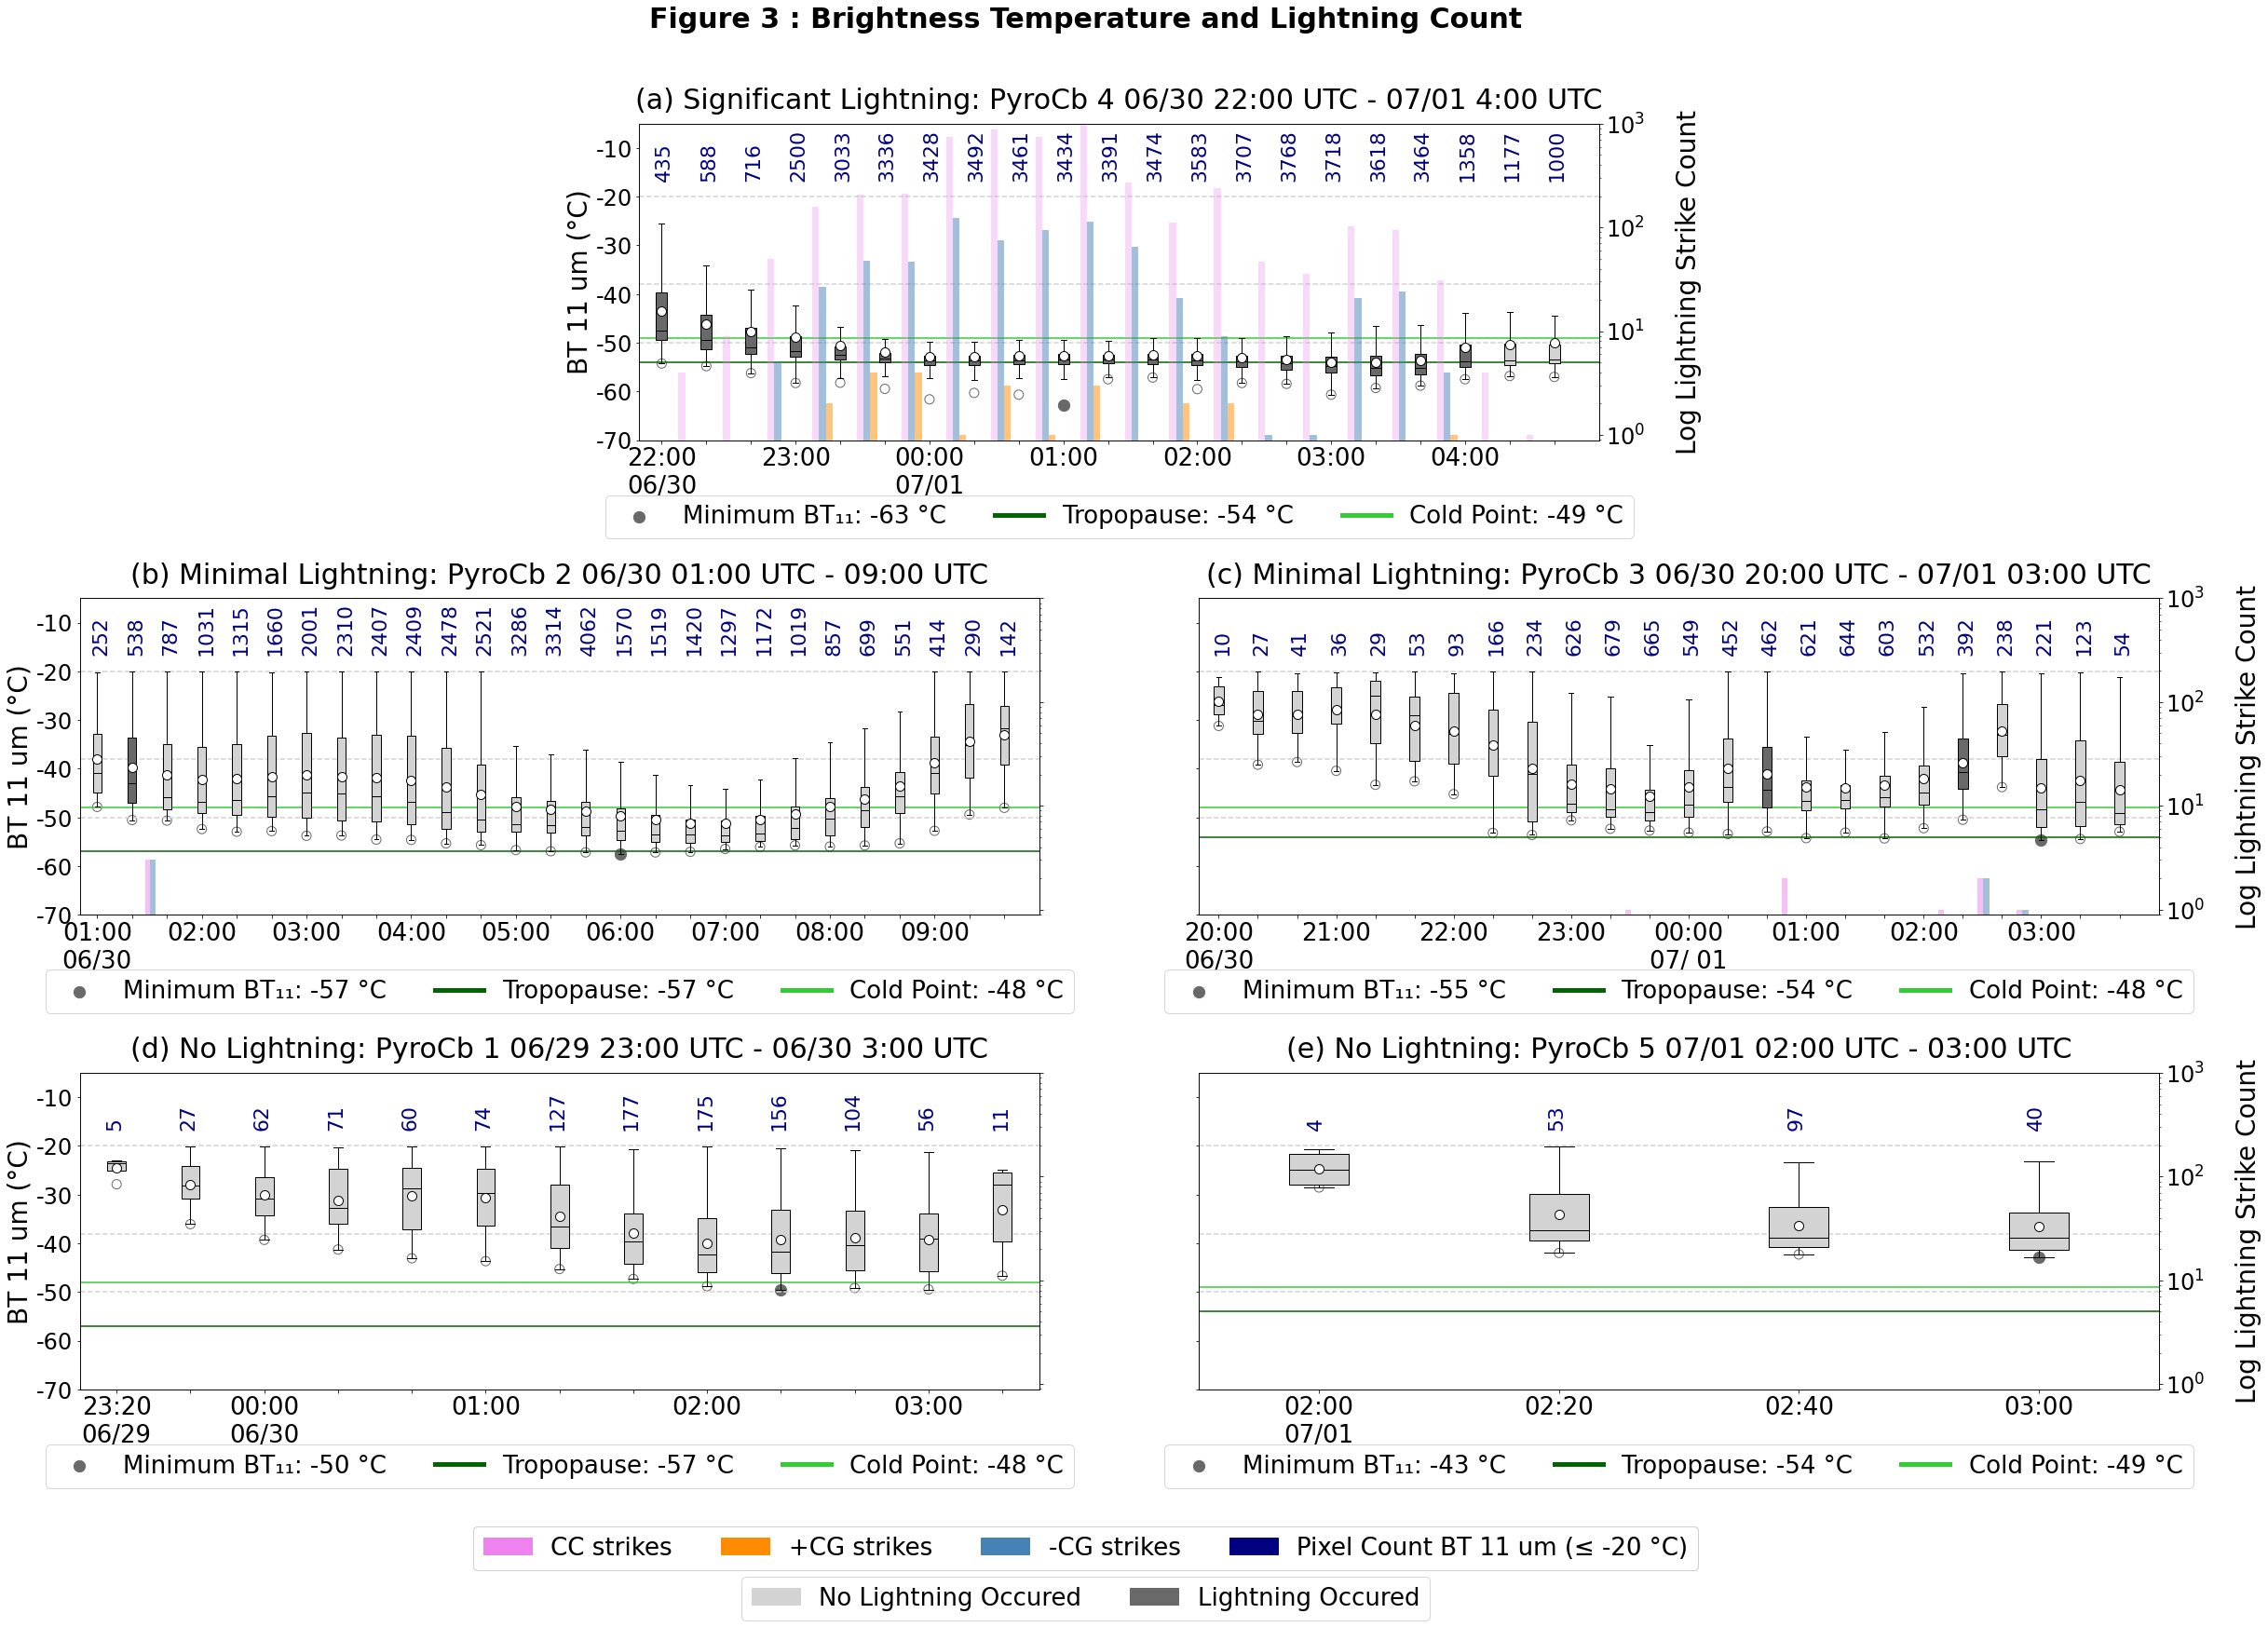

In [72]:
fig, ax = plt.subplots(figsize = (40,25))
degree_sign = u'\N{DEGREE SIGN}'


ax4 = plt.subplot2grid(shape = (3,4), loc = (0,1), colspan=2)
ax4.set_title('(a) Significant Lightning: PyroCb 4 06/30 22:00 UTC - 07/01 4:00 UTC', fontsize = 30, y = 1.03)
ax4.set_ylabel("BT 11 um ({}C)".format(degree_sign), color = "black", fontsize = 28)

#plt.yticks(fontsize = 24, color = "black")
plt.xlim(-1, 42)

plt.ylim(-70,-5)
yticks = np.arange(-70, -5, 10)
ax4.set_yticks(yticks)
ax4.set_yticklabels(yticks, fontsize = 24)

    
plt.axhline(y=-20,  linestyle='--', color = "lightgrey")
plt.axhline(y=-38,  linestyle='--', color = "lightgrey")
plt.axhline(y=-50,  linestyle='--', color = "lightgrey")
plt.axhline(y=-54,  linestyle='-', color = "darkgreen")
plt.axhline(y=-49,  linestyle='-', color = "limegreen")

# Loop for annotation of all points
x = np.arange(0, 41, 2)
for i in range(0, 21, 1):
    ax4.annotate(pyrocb4_len_bt_array[i], (x[i] - 0.3, -16),  rotation=90, fontsize = 22, color = "navy")

    
box4_1 = ax4.boxplot(pyrocb4_bt_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", "markeredgecolor":"black",                                                                             
                  "markersize":"10"}, medianprops=dict(color='black'),  
                   positions = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 
                               40]) 

color4 = ['dimgrey', 'dimgrey',
          'dimgrey', 'dimgrey', 'dimgrey', 'dimgrey','dimgrey', 'dimgrey','dimgrey', 'dimgrey',
          'dimgrey', 'dimgrey','dimgrey', 'dimgrey','dimgrey', 'dimgrey','dimgrey', 'dimgrey',
          'dimgrey', 'lightgrey','lightgrey'] 
for patch, color in zip(box4_1['boxes'], color4):
    patch.set_facecolor(color)

ax4.scatter(np.arange(0, 41, 2), pyrocb4_min, s = 100, facecolors='none', edgecolors='dimgrey') 
ax4.scatter(18, pyrocb4_min[9], s = 150, facecolors='dimgrey', edgecolors='dimgrey', label = "Minimum BT₁₁: {:.0f} {}C".format(np.min(pyrocb4_min), degree_sign)) 
plt.axhline(y=0,  linestyle='-', linewidth = 5, color = "darkgreen", label = "Tropopause: -54 {}C".format(degree_sign))
plt.axhline(y=0,  linestyle='-', linewidth = 5, color = "limegreen", label = "Cold Point: -49 {}C".format(degree_sign))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax4.legend(by_label.values(), by_label.keys(), fontsize = 26, loc='lower center', 
           bbox_to_anchor=(0.5, -0.35), ncol = 3)


# yticks2 = np.arange(0, 8, 1)
ax4_2 = ax4.twinx()
plt.yscale("log")
plt.yticks(fontsize = 24, color = "black")
plt.ylim(0, 1000)

ax4_2.bar(np.arange(0.9, 41.8, 2), pyrocb4_len_cloud_array, color ='violet', width = 0.3, alpha = 0.3)
ax4_2.bar(np.arange(1.2, 42.1, 2), pyrocb4_len_negground_array, color ='steelblue', width = 0.3, alpha = 0.5)
ax4_2.bar(np.arange(1.5, 42.4, 2), pyrocb4_len_posground_array, color ='darkorange', width = 0.3, alpha = 0.5)

ax4_2.spines['right'].set_color('black')
ax4_2.spines['left'].set_color('black')
ax4_2.set_ylabel("Log Lightning Strike Count", color = "black", fontsize = 28)
ax4_2.yaxis.set_label_coords(1.08, .5)

labels = ["22:00 06/30", "", "", "23:00", "", "", 
          "00:00 07/01","", "", "01:00", "", "",
          "02:00","", "","03:00", "", "", "04:00","", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax4.set_xticklabels(labels, fontsize = 26)

# ----------------------------------------------------------------

ax2 = plt.subplot2grid(shape = (3,4), loc = (1,0), colspan=2)
ax2.set_title('(b) Minimal Lightning: PyroCb 2 06/30 01:00 UTC - 09:00 UTC', fontsize = 30, y = 1.03)
ax2.set_ylabel("BT 11 um ({}C)".format(degree_sign), color = "black", fontsize = 28)

plt.ylim(-70,-5)
yticks = np.arange(-70, -5, 10)
ax2.set_yticks(yticks)
ax2.set_yticklabels(yticks, fontsize = 24)

plt.xlim(-1, 54)
plt.axhline(y=-20,  linestyle='--', color = "lightgrey")
plt.axhline(y=-38,  linestyle='--', color = "lightgrey")
plt.axhline(y=-50,  linestyle='--', color = "lightgrey")
plt.axhline(y=-57,  linestyle='-', color = "darkgreen")
plt.axhline(y=-48,  linestyle='-', color = "limegreen")

11.173137898798712

# Loop for annotation of all points
x = np.arange(0, 53, 2)
for i in range(0, 27, 1):
    ax2.annotate(pyrocb2_len_bt_array[i], (x[i] - 0.3, -16),  rotation=90, fontsize = 22, color = "navy")

box2_1 = ax2.boxplot(pyrocb2_bt_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", "markeredgecolor":"black",                                                                             
                  "markersize":"10"}, medianprops=dict(color='black'),  
                   positions = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 
                               40, 42, 44, 46, 48, 50, 52]) 


color2 = ['lightgrey', 'dimgrey', 
          'lightgrey', 'lightgrey','lightgrey', 'lightgrey','lightgrey', 'lightgrey', 
         'lightgrey', 'lightgrey','lightgrey', 'lightgrey','lightgrey', 'lightgrey',
         'lightgrey', 'lightgrey','lightgrey', 'lightgrey','lightgrey', 'lightgrey',
         'lightgrey', 'lightgrey','lightgrey', 'lightgrey','lightgrey', 'lightgrey',
         'lightgrey', 'lightgrey'] 
for patch, color in zip(box2_1['boxes'], color2):
    patch.set_facecolor(color)

ax2.scatter(np.arange(0, 53, 2), pyrocb2_min, s = 100, facecolors='none', edgecolors='dimgrey') 
ax2.scatter(30, pyrocb2_min[15], s = 150, facecolors='dimgrey', edgecolors='dimgrey', label = "Minimum BT₁₁: {:.0f} {}C".format(np.min(pyrocb2_min), degree_sign)) 
plt.axhline(y=0,  linestyle='-', linewidth = 5, color = "darkgreen", label = "Tropopause: -57 {}C".format(degree_sign))
plt.axhline(y=0,  linestyle='-', linewidth = 5, color = "limegreen", label = "Cold Point: -48 {}C".format(degree_sign))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax2.legend(by_label.values(), by_label.keys(), fontsize = 26, loc='lower center', 
           bbox_to_anchor=(0.5, -0.35), ncol = 3)


yticks2 = np.arange(0, 8, 1)
ax2_2 = ax2.twinx()
plt.yscale("log")
plt.yticks(fontsize = 24, color = "white")
plt.ylim(0, 1000)

ax2_2.bar(np.arange(0.9, 53.8, 2), pyrocb2_len_cloud_array, color ='violet', width = 0.3, alpha = 0.5)
ax2_2.bar(np.arange(1.2, 54.1, 2), pyrocb2_len_negground_array, color ='steelblue', width = 0.3, alpha = 0.5)
ax2_2.bar(np.arange(1.5, 54.4, 2), pyrocb2_len_posground_array, color ='darkorange', width = 0.3, alpha = 0.5)

ax2_2.spines['right'].set_color('black')
ax2_2.spines['left'].set_color('black')

labels = ["01:00 06/30", "", "",
          "02:00","", "", "03:00", "", "",
          "04:00","", "",  "05:00","", "",
          "06:00","", "",  "07:00","", "",
          "08:00","", "",  "09:00", "", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax2.set_xticklabels(labels, fontsize = 26)


# ----------------------------------------------------------------

ax3 = plt.subplot2grid(shape = (3,4), loc = (1,2), colspan=2)
ax3.set_title('(c) Minimal Lightning: PyroCb 3 06/30 20:00 UTC - 07/01 03:00 UTC', fontsize = 30, y = 1.03)

plt.ylim(-70,-5)
yticks = np.arange(-70, -5, 10)
ax3.set_yticks(yticks)
ax3.set_yticklabels(yticks, fontsize = 24, color = "white")

plt.xlim(-1, 48)
plt.axhline(y=-20,  linestyle='--', color = "lightgrey")
plt.axhline(y=-38,  linestyle='--', color = "lightgrey")
plt.axhline(y=-50,  linestyle='--', color = "lightgrey")
plt.axhline(y=-54,  linestyle='-', color = "darkgreen")
plt.axhline(y=-48,  linestyle='-', color = "limegreen")

# Loop for annotation of all points
x = np.arange(0, 47, 2)
for i in range(0, 24, 1):
    ax3.annotate(pyrocb3_len_bt_array[i], (x[i] - 0.3, -16),  rotation=90, fontsize = 22, color = "navy")

box3_1 = ax3.boxplot(pyrocb3_bt_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", "markeredgecolor":"black",                                                                             
                  "markersize":"10"}, medianprops=dict(color='black'), 
                   positions = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 
                               40, 42, 44, 46]) 


color3 = ['lightgrey', 'lightgrey','lightgrey', 'lightgrey','lightgrey', 'lightgrey', 
         'lightgrey', 'lightgrey','lightgrey', 'lightgrey','lightgrey', 'lightgrey',
         'lightgrey', 'lightgrey','dimgrey', 'lightgrey','lightgrey', 'lightgrey',
         'lightgrey', 'dimgrey', 'lightgrey', 'lightgrey', 'lightgrey','lightgrey'] 
for patch, color in zip(box3_1['boxes'], color3):
    patch.set_facecolor(color)
    
ax3.scatter(np.arange(0, 47, 2), pyrocb3_min, s = 100, facecolors='none', edgecolors='dimgrey') 
ax3.scatter(42, pyrocb3_min[21], s = 150, facecolors='dimgrey', edgecolors='dimgrey', label = "Minimum BT₁₁: {:.0f} {}C".format(np.min(pyrocb3_min), degree_sign)) 
plt.axhline(y=0,  linestyle='-', linewidth = 5, color = "darkgreen", label = "Tropopause: -54 {}C".format(degree_sign))
plt.axhline(y=0,  linestyle='-', linewidth = 5, color = "limegreen", label = "Cold Point: -48 {}C".format(degree_sign))


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax3.legend(by_label.values(), by_label.keys(), fontsize = 26, loc='lower center', 
           bbox_to_anchor=(0.5, -0.35), ncol = 3)
    
    
yticks2 = np.arange(0, 8, 1)
ax3_2 = ax3.twinx()
plt.yscale("log")
plt.yticks(fontsize = 24, color = "black")
plt.ylim(0,1000)


ax3_2.bar(np.arange(0.9, 47.8, 2), pyrocb3_len_cloud_array, color ='violet', width = 0.3, alpha = 0.5)
ax3_2.bar(np.arange(1.2, 48.1, 2), pyrocb3_len_negground_array, color ='steelblue', width = 0.3, alpha = 0.5)
ax3_2.bar(np.arange(1.5, 48.4, 2), pyrocb3_len_posground_array, color ='darkorange', width = 0.3, alpha = 0.5)


ax3_2.spines['right'].set_color('black')
ax3_2.spines['left'].set_color('black')
ax3_2.set_ylabel("Log Lightning Strike Count", color = "black", fontsize = 28)
ax3_2.yaxis.set_label_coords(1.08, .5)

labels = ["20:00 06/30","", "",  "21:00", "", "", 
          "22:00","", "", "23:00","", "", 
          "00:00 07/ 01","", "", "01:00","", "",
          "02:00","", "", "03:00","", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax3.set_xticklabels(labels, fontsize = 26)

# ----------------------------------------------------------------


ax1 = plt.subplot2grid(shape = (3,4), loc = (2,0), colspan=2)
ax1.set_title('(d) No Lightning: PyroCb 1 06/29 23:00 UTC - 06/30 3:00 UTC', fontsize = 30, y = 1.03)
ax1.set_ylabel("BT 11 um ({}C)".format(degree_sign), color = "black", fontsize = 28)

plt.ylim(-70,-5)
yticks = np.arange(-70, -5, 10)
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, fontsize = 24)

plt.xlim(-1, 25)
plt.axhline(y=-20,  linestyle='--', color = "lightgrey")
plt.axhline(y=-38,  linestyle='--', color = "lightgrey")
plt.axhline(y=-50,  linestyle='--', color = "lightgrey")
plt.axhline(y=-57,  linestyle='-', color = "darkgreen")
plt.axhline(y=-48,  linestyle='-', color = "limegreen")

x = np.arange(0, 28, 2)
for i in range(0, 13, 1):
    ax1.annotate(pyrocb1_len_bt_array[1:-1][i], (x[i] - 0.3, -16),  rotation=90, fontsize = 22, color = "navy")

box1 = ax1.boxplot(pyrocb1_bt_array[1:-1], showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", "markeredgecolor":"black",                                                                             
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops = dict(facecolor = "lightgrey"), 
                   positions = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]) 

ax1.scatter(np.arange(0, 25, 2), pyrocb1_min, s = 100, facecolors='none', edgecolors='dimgrey') 
ax1.scatter(18, pyrocb1_min[9], s = 150, facecolors='dimgrey', edgecolors='dimgrey', label = "Minimum BT₁₁: {:.0f} {}C".format(np.min(pyrocb1_min), degree_sign)) 
plt.axhline(y=0,  linestyle='-', linewidth = 5, color = "darkgreen", label = "Tropopause: -57 {}C".format(degree_sign))
plt.axhline(y=0,  linestyle='-', linewidth = 5, color = "limegreen", label = "Cold Point: -48 {}C".format(degree_sign))


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), fontsize = 26, loc='lower center', 
           bbox_to_anchor=(0.5, -0.35), ncol = 3)


yticks2 = np.arange(0, 8, 1)
ax1_2 = ax1.twinx()
plt.yscale("log")
plt.yticks(fontsize = 24, color = "white")
plt.ylim(0, 1000)


# ax1_2.bar(np.arange(0.9, 29.8, 2), pyrocb1_len_cloud_array, color ='violet', width = 0.3, alpha = 0.5)
# ax1_2.bar(np.arange(1.2, 30.1, 2), pyrocb1_len_negground_array, color ='steelblue', width = 0.3, alpha = 0.5)
# ax1_2.bar(np.arange(1.5, 30.4, 2), pyrocb1_len_posground_array, color ='darkorange', width = 0.3, alpha = 0.5)

ax1_2.spines['right'].set_color('black')
ax1_2.spines['left'].set_color('black')


labels = ["23:20 06/29", "", 
          "00:00 06/30","", "", "01:00", "", "",
          "02:00","", "","03:00", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax1.set_xticklabels(labels, fontsize = 26)


# ----------------------------------------------------------------

ax5 = plt.subplot2grid(shape = (3,4), loc = (2,2), colspan=2)
ax5.set_title('(e) No Lightning: PyroCb 5 07/01 02:00 UTC - 03:00 UTC', fontsize = 30, y = 1.03)

plt.ylim(-70,-5)
yticks = np.arange(-70, -5, 10)
ax5.set_yticks(yticks)
ax5.set_yticklabels(yticks, fontsize = 24, color = "white")

plt.xlim(-1, 7)

plt.axhline(y=-20,  linestyle='--', color = "lightgrey")
plt.axhline(y=-38,  linestyle='--', color = "lightgrey")
plt.axhline(y=-50,  linestyle='--', color = "lightgrey")
plt.axhline(y=-54,  linestyle='-', color = "darkgreen")
plt.axhline(y=-49,  linestyle='-', color = "limegreen")

x = np.arange(0, 8, 2)
for i in range(0, 4, 1):
    ax5.annotate(pyrocb5_len_bt_array[i], (x[i] - 0.1, -16), rotation=90, fontsize = 22, color = "navy")

box5_1 = ax5.boxplot(pyrocb5_bt_array[:-2], showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", "markeredgecolor":"black",                                                                             
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops = dict(facecolor = "lightgrey"), 
                   positions = [0, 2, 4, 6]) 

ax5.scatter(np.arange(0, 7, 2), pyrocb5_min, s = 100, facecolors='none', edgecolors='dimgrey') 
ax5.scatter(6, pyrocb5_min[3], s = 150, facecolors='dimgrey', edgecolors='dimgrey', label = "Minimum BT₁₁: {:.0f} {}C".format(np.min(pyrocb5_min), degree_sign)) 
plt.axhline(y=0,  linestyle='-', linewidth = 5, color = "darkgreen", label = "Tropopause: -54 {}C".format(degree_sign))
plt.axhline(y=0,  linestyle='-', linewidth = 5, color = "limegreen", label = "Cold Point: -49 {}C".format(degree_sign))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax5.legend(by_label.values(), by_label.keys(), fontsize = 26, loc='lower center', 
           bbox_to_anchor=(0.5, -0.35), ncol = 3)

yticks2 = np.arange(0, 8, 1)
ax5_2 = ax5.twinx()
plt.yscale("log")
plt.yticks(fontsize = 24, color = "black")
plt.ylim(0, 1000)


# ax5_2.bar(np.arange(0.9, 11.8, 2), pyrocb5_len_cloud_array, color ='violet', width = 0.3, alpha = 0.5)
# ax5_2.bar(np.arange(1.2, 12.1, 2), pyrocb5_len_negground_array, color ='steelblue', width = 0.3, alpha = 0.5)
# ax5_2.bar(np.arange(1.5, 12.4, 2), pyrocb5_len_posground_array, color ='darkorange', width = 0.3, alpha = 0.5)


ax5_2.spines['right'].set_color('black')
ax5_2.spines['left'].set_color('black')
ax5_2.set_ylabel("Log Lightning Strike Count", color = "black", fontsize = 28)
ax5_2.yaxis.set_label_coords(1.08, .5)


labels = [ "02:00 07/01","02:20", "02:40", "03:00"]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax5.set_xticklabels(labels, fontsize = 26)

# ----------------------------------------------------------------


CC = mpatches.Patch(facecolor='violet', edgecolor = "violet", label=("CC strikes".format(str(np.sum(pyrocb3_len_cloud_array)))))
negCG = mpatches.Patch(facecolor='steelblue', edgecolor = "steelblue", label=("-CG strikes".format(str(np.sum(pyrocb3_len_negground_array)))))
posCG = mpatches.Patch(facecolor='darkorange', edgecolor = "darkorange", label=("+CG strikes".format(str(np.sum(pyrocb3_len_posground_array)))))
btcount = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Pixel Count BT 11 um (≤ -20 {}C)".format(degree_sign)))

firstlegend =  fig.legend(handles=[CC, posCG, negCG, btcount], loc='lower center', 
            bbox_to_anchor=(0.5, 0.01),
            ncol=4, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)
fig.add_artist(firstlegend)

lightgrey = mpatches.Patch(facecolor='lightgrey', edgecolor = "lightgrey", label=("No Lightning Occured"))
darkgrey = mpatches.Patch(facecolor='dimgrey', edgecolor = "dimgrey", label=("Lightning Occured"))

fig.legend(handles=[lightgrey, darkgrey], loc='lower center', 
            bbox_to_anchor=(0.5, -0.02),
            ncol=2, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)


plt.suptitle("Figure 3 : Brightness Temperature and Lightning Count", x = 0.5, y = 0.95, fontweight='bold', fontsize=30)
plt.subplots_adjust(hspace=0.5, wspace=0.4)

plt.savefig("bt_timeseries_allpyrocbs", bbox_inches = "tight", dpi = 600)
plt.show()




# smoke and clean time series

In [73]:
smoke_min = []
for i in range(0, 8): 
    smoke_min.append(np.min(smoke_bt_array[3:11][i]))

clean1_min = []
for j in range(0, 18): 
    clean1_min.append(np.min(clean1_bt_array[j]))

clean2_min = []
for k in range(0, 24): 
    clean2_min.append(np.min(clean2_bt_array[k]))

clean3_min = []
for l in range(0, 19): 
    clean3_min.append(np.min(clean3_bt_array[2:][l]))

clean4_min = []
for m in range(0, 13): 
    clean4_min.append(np.min(clean4_bt_array[2:][m]))

clean5_min = []
for n in range(0, 15): 
    clean5_min.append(np.min(clean5_bt_array[3:][n]))


/tmp/ipykernel_286541/1314206438.py:50: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1000)
/tmp/ipykernel_286541/1314206438.py:108: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1000)
/tmp/ipykernel_286541/1314206438.py:177: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1000)
/tmp/ipykernel_286541/1314206438.py:238: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1000)
/tmp/ipykernel_286541/1314206438.py:296: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1000)
/tmp/ipykernel_286541/1314206438.py:354: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.y

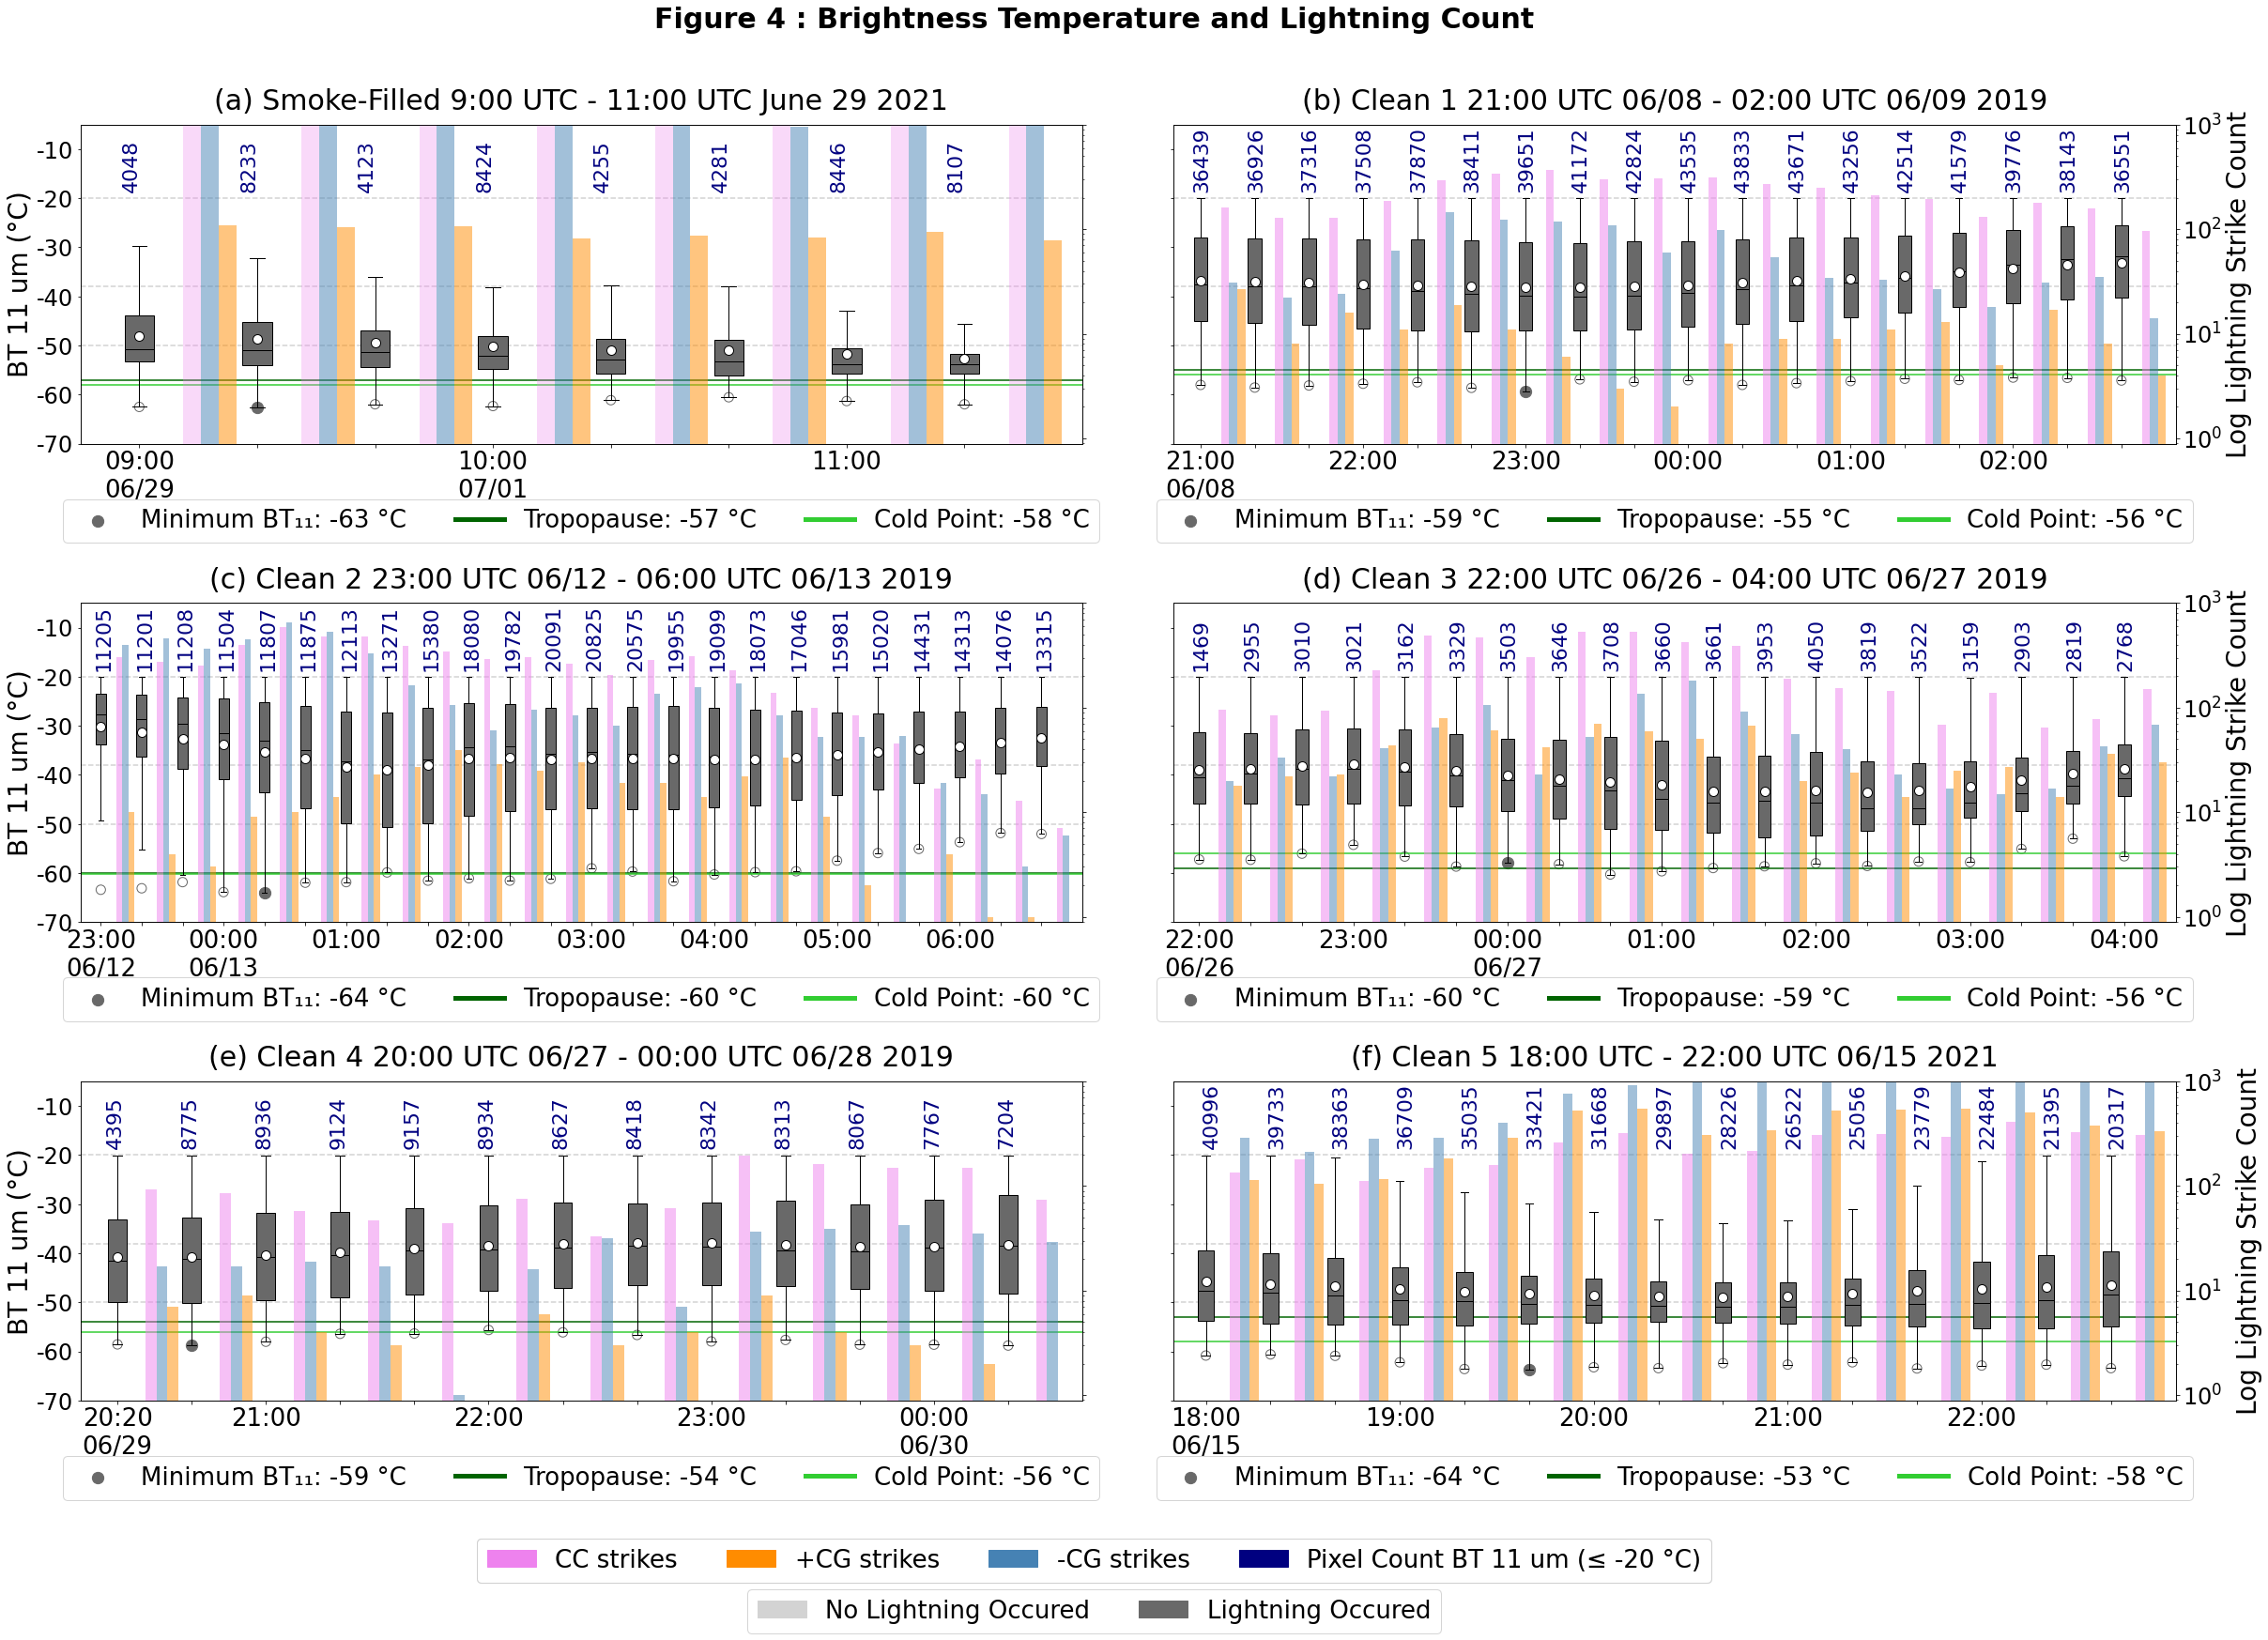

In [78]:
fig, ax = plt.subplots(figsize = (40,25))
degree_sign = u'\N{DEGREE SIGN}'


ax4 = plt.subplot2grid(shape = (3,4), loc = (0,0), colspan=2)
ax4.set_title('(a) Smoke-Filled 9:00 UTC - 11:00 UTC June 29 2021', fontsize = 30, y = 1.03)
ax4.set_ylabel("BT 11 um ({}C)".format(degree_sign), color = "black", fontsize = 28)

plt.yticks(fontsize = 24, color = "black")
plt.xlim(-1, 16)

# y ticks 
plt.ylim(-70,-5)
yticks = np.arange(-70, -5, 10)
ax4.set_yticks(yticks)
ax4.set_yticklabels(yticks, fontsize = 24)


plt.axhline(y=-20,  linestyle='--', color = "lightgrey")
plt.axhline(y=-38,  linestyle='--', color = "lightgrey")
plt.axhline(y=-50,  linestyle='--', color = "lightgrey")
plt.axhline(y=-57,  linestyle='-', color = "darkgreen")
plt.axhline(y=-58,  linestyle='-', color = "limegreen")

# Loop for annotation of all points
x = np.arange(0, 15, 2)
for i in range(0, 8, 1):
    ax4.annotate(smoke_len_bt_array[3:11][i], (x[i] - 0.3, -18),  rotation=90, fontsize = 22, color = "navy")

    
box4_1 = ax4.boxplot(smoke_bt_array[3:11], showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", "markeredgecolor":"black",                                                                             
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops=dict(facecolor="dimgrey"), 
                   positions = [0, 2, 4, 6, 8, 10, 12, 14]) 

ax4.scatter(np.arange(0, 15, 2), smoke_min, s = 100, facecolors='none', edgecolors='dimgrey') 
ax4.scatter(2, smoke_min[1], s = 150, facecolors='dimgrey', edgecolors='dimgrey', label = "Minimum BT₁₁: {:.0f} {}C".format(np.min(smoke_min), degree_sign)) 
plt.axhline(y=0, linewidth = 5, linestyle='-', color = "darkgreen", label = "Tropopause: -57 {}C".format(degree_sign))
plt.axhline(y=0,  linewidth = 5, linestyle='-', color = "limegreen", label = "Cold Point: -58 {}C".format(degree_sign))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax4.legend(by_label.values(), by_label.keys(), fontsize = 26, loc='lower center', 
           bbox_to_anchor=(0.5, -0.35), ncol = 3)


ax4_2 = ax4.twinx()
plt.yscale("log")
plt.yticks(fontsize = 24, color = "white")
plt.ylim(0, 1000)

ax4_2.bar(np.arange(0.9, 15.8, 2), smoke_len_cloud_array[3:11], color ='violet', width = 0.3, alpha = 0.3)
ax4_2.bar(np.arange(1.2, 16.1, 2), smoke_len_negground_array[3:11], color ='steelblue', width = 0.3, alpha = 0.5)
ax4_2.bar(np.arange(1.5, 16.4, 2), smoke_len_posground_array[3:11], color ='darkorange', width = 0.3, alpha = 0.5)

ax4_2.spines['right'].set_color('black')
ax4_2.spines['left'].set_color('black')
ax4_2.yaxis.set_label_coords(1.08, .5)

labels = ["09:00  06/29", "", "", 
          "10:00 07/01","", "", "11:00", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax4.set_xticklabels(labels, fontsize = 26)

# ----------------------------------------------------------------

ax2 = plt.subplot2grid(shape = (3,4), loc = (0,2), colspan=2)
ax2.set_title('(b) Clean 1 21:00 UTC 06/08 - 02:00 UTC 06/09 2019', fontsize = 30, y = 1.03)

plt.ylim(-70,-5)
yticks = np.arange(-70, -5, 10)
ax2.set_yticks(yticks)
ax2.set_yticklabels(yticks, fontsize = 24, color = "white")


plt.xlim(-1, 36)
plt.axhline(y=-20,  linestyle='--', color = "lightgrey")
plt.axhline(y=-38,  linestyle='--', color = "lightgrey")
plt.axhline(y=-50,  linestyle='--', color = "lightgrey")
plt.axhline(y=-55,  linestyle='-', color = "darkgreen")
plt.axhline(y=-56,  linestyle='-', color = "limegreen")

# Loop for annotation of all points
x = np.arange(0, 35, 2)
for i in range(0, 18, 1):
    ax2.annotate(clean1_len_bt_array[i], (x[i] - 0.3, -18),  rotation=90, fontsize = 22, color = "navy")

box2_1 = ax2.boxplot(clean1_bt_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", "markeredgecolor":"black",                                                                             
                  "markersize":"10"}, medianprops=dict(color='black'),  boxprops=dict(facecolor="dimgrey"),
                   positions = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34]) 

ax2.scatter(np.arange(0, 35, 2), clean1_min, s = 100, facecolors='none', edgecolors='dimgrey') 
ax2.scatter(12, clean1_min[6], s = 150, facecolors='dimgrey', edgecolors='dimgrey', label = "Minimum BT₁₁: {:.0f} {}C".format(np.min(clean1_min), degree_sign)) 
plt.axhline(y=0, linewidth = 5, linestyle='-', color = "darkgreen", label = "Tropopause: -55 {}C".format(degree_sign))
plt.axhline(y=0,  linewidth = 5, linestyle='-', color = "limegreen", label = "Cold Point: -56 {}C".format(degree_sign))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax2.legend(by_label.values(), by_label.keys(), fontsize = 26, loc='lower center', 
           bbox_to_anchor=(0.5, -0.35), ncol = 3)


ax2_2 = ax2.twinx()
plt.yscale("log")
plt.yticks(fontsize = 24, color = "black")
ax2_2.set_ylabel("Log Lightning Strike Count", color = "black", fontsize = 28)
plt.ylim(0, 1000)

ax2_2.bar(np.arange(0.9, 35.8, 2), clean1_len_cloud_array, color ='violet', width = 0.3, alpha = 0.5)
ax2_2.bar(np.arange(1.2, 36.1, 2), clean1_len_negground_array, color ='steelblue', width = 0.3, alpha = 0.5)
ax2_2.bar(np.arange(1.5, 36.4, 2), clean1_len_posground_array, color ='darkorange', width = 0.3, alpha = 0.5)

ax2_2.spines['right'].set_color('black')
ax2_2.spines['left'].set_color('black')

labels = ["21:00 06/08", "", "",
          "22:00","", "", "23:00", "", "",
          "00:00","", "",  "01:00","", "",
          "02:00","", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax2.set_xticklabels(labels, fontsize = 26)


# ----------------------------------------------------------------

ax3 = plt.subplot2grid(shape = (3,4), loc = (1,0), colspan=2)
ax3.set_title('(c) Clean 2 23:00 UTC 06/12 - 06:00 UTC 06/13 2019', fontsize = 30, y = 1.03)
ax3.set_ylabel("BT 11 um ({}C)".format(degree_sign), color = "black", fontsize = 28)

plt.ylim(-70,-5)
yticks = np.arange(-70, -5, 10)
ax3.set_yticks(yticks)
ax3.set_yticklabels(yticks, fontsize = 24)

plt.xlim(-1, 48)
plt.axhline(y=-20,  linestyle='--', color = "lightgrey")
plt.axhline(y=-38,  linestyle='--', color = "lightgrey")
plt.axhline(y=-50,  linestyle='--', color = "lightgrey")
plt.axhline(y=-60,  linestyle='-', color = "darkgreen")
plt.axhline(y=-60.3,  linestyle='-', color = "limegreen")

# Loop for annotation of all points
x = np.arange(0, 47, 2)
for i in range(0, 24, 1):
    ax3.annotate(clean2_len_bt_array[i], (x[i] - 0.3, -18),  rotation=90, fontsize = 22, color = "navy")

box3_1 = ax3.boxplot(clean2_bt_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", "markeredgecolor":"black",                                                                             
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops=dict(facecolor="dimgrey"),
                   positions = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 
                               40, 42, 44, 46]) 


# color3 = ['lightgrey', 'lightgrey','lightgrey', 'lightgrey','lightgrey', 'lightgrey', 
#          'lightgrey', 'lightgrey','lightgrey', 'lightgrey','lightgrey', 'lightgrey',
#          'lightgrey', 'lightgrey','dimgrey', 'lightgrey','lightgrey', 'lightgrey',
#          'lightgrey', 'dimgrey', 'lightgrey', 'lightgrey', 'lightgrey','lightgrey'] 
# for patch, color in zip(box3_1['boxes'], color3):
#     patch.set_facecolor(color)
    
ax3.scatter(np.arange(0, 47, 2), clean2_min, s = 100, facecolors='none', edgecolors='dimgrey') 
ax3.scatter(8, clean2_min[4], s = 150, facecolors='dimgrey', edgecolors='dimgrey', label = "Minimum BT₁₁: {:.0f} {}C".format(np.min(clean2_min), degree_sign)) 
plt.axhline(y=0, linewidth = 5, linestyle='-', color = "darkgreen", label = "Tropopause: -60 {}C".format(degree_sign))
plt.axhline(y=0,  linewidth = 5, linestyle='-', color = "limegreen", label = "Cold Point: -60 {}C".format(degree_sign))


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax3.legend(by_label.values(), by_label.keys(), fontsize = 26, loc='lower center', 
           bbox_to_anchor=(0.5, -0.35), ncol = 3)
    
    
ax3_2 = ax3.twinx()
plt.yscale("log")
plt.yticks(fontsize = 24, color = "white")
plt.ylim(0, 1000)

ax3_2.bar(np.arange(0.9, 47.8, 2), clean2_len_cloud_array, color ='violet', width = 0.3, alpha = 0.5)
ax3_2.bar(np.arange(1.2, 48.1, 2), clean2_len_negground_array, color ='steelblue', width = 0.3, alpha = 0.5)
ax3_2.bar(np.arange(1.5, 48.4, 2), clean2_len_posground_array, color ='darkorange', width = 0.3, alpha = 0.5)


ax3_2.spines['right'].set_color('black')
ax3_2.spines['left'].set_color('black')
ax3_2.yaxis.set_label_coords(1.08, .5)

labels = ["23:00 06/12","", "", 
          "00:00 06/13","", "", "01:00","", "",
          "02:00","", "", "03:00","", "", "04:00","", "",
          "05:00","", "", "06:00","", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax3.set_xticklabels(labels, fontsize = 26)

# ----------------------------------------------------------------


ax1 = plt.subplot2grid(shape = (3,4), loc = (1,2), colspan=2)
ax1.set_title('(d) Clean 3 22:00 UTC 06/26 - 04:00 UTC 06/27 2019', fontsize = 30, y = 1.03)

plt.ylim(-70,-5)
yticks = np.arange(-70, -5, 10)
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, fontsize = 24, color = "white")

plt.xlim(-1, 38)
plt.axhline(y=-20,  linestyle='--', color = "lightgrey")
plt.axhline(y=-38,  linestyle='--', color = "lightgrey")
plt.axhline(y=-50,  linestyle='--', color = "lightgrey")
plt.axhline(y=-59,  linestyle='-', color = "darkgreen")
plt.axhline(y=-56,  linestyle='-', color = "limegreen")

x = np.arange(0, 38, 2)
for i in range(0, 19, 1):
    ax1.annotate(clean3_len_bt_array[2:][i], (x[i] - 0.3, -18),  rotation=90, fontsize = 22, color = "navy")

box1 = ax1.boxplot(clean3_bt_array[2:], showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", "markeredgecolor":"black",                                                                             
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops = dict(facecolor = "dimgrey"), 
                   positions = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36]) 

ax1.scatter(np.arange(0, 38, 2), clean3_min, s = 100, facecolors='none', edgecolors='dimgrey') 
ax1.scatter(12, clean3_min[6], s = 150, facecolors='dimgrey', edgecolors='dimgrey', label = "Minimum BT₁₁: {:.0f} {}C".format(np.min(clean3_min), degree_sign)) 
plt.axhline(y=0, linewidth = 5, linestyle='-', color = "darkgreen", label = "Tropopause: -59 {}C".format(degree_sign))
plt.axhline(y=0,  linewidth = 5, linestyle='-', color = "limegreen", label = "Cold Point: -56 {}C".format(degree_sign))


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), fontsize = 26, loc='lower center', 
           bbox_to_anchor=(0.5, -0.35), ncol = 3)


ax1_2 = ax1.twinx()
plt.yscale("log")
plt.yticks(fontsize = 24, color = "black")
ax1_2.set_ylabel("Log Lightning Strike Count", color = "black", fontsize = 28)
plt.ylim(0, 1000)

ax1_2.bar(np.arange(0.9, 37.8, 2), clean3_len_cloud_array[2:], color ='violet', width = 0.3, alpha = 0.5)
ax1_2.bar(np.arange(1.2, 38.1, 2), clean3_len_negground_array[2:], color ='steelblue', width = 0.3, alpha = 0.5)
ax1_2.bar(np.arange(1.5, 38.4, 2), clean3_len_posground_array[2:], color ='darkorange', width = 0.3, alpha = 0.5)

ax1_2.spines['right'].set_color('black')
ax1_2.spines['left'].set_color('black')


labels = [ "22:00 06/26","", "", "23:00","", "", "00:00 06/27", "", "",
          "01:00","", "","02:00", "","", "03:00", "", "", "04:00"]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax1.set_xticklabels(labels, fontsize = 26)


# ----------------------------------------------------------------


ax6 = plt.subplot2grid(shape = (3,4), loc = (2,0), colspan=2)
ax6.set_title('(e) Clean 4 20:00 UTC 06/27 - 00:00 UTC 06/28 2019', fontsize = 30, y = 1.03)
ax6.set_ylabel("BT 11 um ({}C)".format(degree_sign), color = "black", fontsize = 28)

plt.ylim(-70,-5)
yticks = np.arange(-70, -5, 10)
ax6.set_yticks(yticks)
ax6.set_yticklabels(yticks, fontsize = 24)

plt.xlim(-1, 26)
plt.axhline(y=-20,  linestyle='--', color = "lightgrey")
plt.axhline(y=-38,  linestyle='--', color = "lightgrey")
plt.axhline(y=-50,  linestyle='--', color = "lightgrey")
plt.axhline(y=-54,  linestyle='-', color = "darkgreen")
plt.axhline(y=-56,  linestyle='-', color = "limegreen")

x = np.arange(0, 26, 2)
for i in range(0, 13, 1):
    ax6.annotate(clean4_len_bt_array[2:][i], (x[i] - 0.3, -18),  rotation=90, fontsize = 22, color = "navy")

box1 = ax6.boxplot(clean4_bt_array[2:], showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", "markeredgecolor":"black",                                                                             
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops = dict(facecolor = "dimgrey"), 
                   positions = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]) 

ax6.scatter(np.arange(0, 25, 2), clean4_min, s = 100, facecolors='none', edgecolors='dimgrey') 
ax6.scatter(2, clean4_min[1], s = 150, facecolors='dimgrey', edgecolors='dimgrey', label = "Minimum BT₁₁: {:.0f} {}C".format(np.min(clean4_min), degree_sign)) 
plt.axhline(y=0, linewidth = 5, linestyle='-', color = "darkgreen", label = "Tropopause: -54 {}C".format(degree_sign))
plt.axhline(y=0,  linewidth = 5, linestyle='-', color = "limegreen", label = "Cold Point: -56 {}C".format(degree_sign))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax6.legend(by_label.values(), by_label.keys(), fontsize = 26, loc='lower center', 
           bbox_to_anchor=(0.5, -0.35), ncol = 3)


ax6_2 = ax6.twinx()
plt.yscale("log")
plt.yticks(fontsize = 24, color = "white")
plt.ylim(0, 1000)

ax6_2.bar(np.arange(0.9, 25.8, 2), clean4_len_cloud_array[2:], color ='violet', width = 0.3, alpha = 0.5)
ax6_2.bar(np.arange(1.2, 26.1, 2), clean4_len_negground_array[2:], color ='steelblue', width = 0.3, alpha = 0.5)
ax6_2.bar(np.arange(1.5, 26.4, 2), clean4_len_posground_array[2:], color ='darkorange', width = 0.3, alpha = 0.5)

ax6_2.spines['right'].set_color('black')
ax6_2.spines['left'].set_color('black')


labels = ["20:20 06/29", "", 
          "21:00","", "", "22:00", "", "",
          "23:00","", "","00:00 06/30", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax6.set_xticklabels(labels, fontsize = 26)



# ----------------------------------------------------------------

ax5 = plt.subplot2grid(shape = (3,4), loc = (2,2), colspan=2)
ax5.set_title('(f) Clean 5 18:00 UTC - 22:00 UTC 06/15 2021', fontsize = 30, y = 1.03)

plt.ylim(-70,-5)
yticks = np.arange(-70, -5, 10)
ax5.set_yticks(yticks)
ax5.set_yticklabels(yticks, fontsize = 24, color = "white")

plt.xlim(-1, 30)

plt.axhline(y=-20,  linestyle='--', color = "lightgrey")
plt.axhline(y=-38,  linestyle='--', color = "lightgrey")
plt.axhline(y=-50,  linestyle='--', color = "lightgrey")
plt.axhline(y=-53,  linestyle='-', color = "darkgreen")
plt.axhline(y=-58,  linestyle='-', color = "limegreen")

x = np.arange(0, 30, 2)
for i in range(0, 15, 1):
    ax5.annotate(clean5_len_bt_array[3:][i], (x[i] - 0.1, -18), rotation=90, fontsize = 22, color = "navy")

box5_1 = ax5.boxplot(clean5_bt_array[3:], showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", "markeredgecolor":"black",                                                                             
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops = dict(facecolor = "dimgrey"), 
                   positions = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]) 

ax5.scatter(np.arange(0, 30, 2), clean5_min, s = 100, facecolors='none', edgecolors='dimgrey') 
ax5.scatter(10, clean5_min[5], s = 150, facecolors='dimgrey', edgecolors='dimgrey', label = "Minimum BT₁₁: {:.0f} {}C".format(np.min(clean5_min), degree_sign)) 
plt.axhline(y=0, linewidth = 5, linestyle='-', color = "darkgreen", label = "Tropopause: -53 {}C".format(degree_sign))
plt.axhline(y=0,  linewidth = 5, linestyle='-', color = "limegreen", label = "Cold Point: -58 {}C".format(degree_sign))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax5.legend(by_label.values(), by_label.keys(), fontsize = 26, loc='lower center', 
           bbox_to_anchor=(0.5, -0.35), ncol = 3)

ax5_2 = ax5.twinx()
plt.yscale("log")
plt.yticks(fontsize = 24, color = "black")
plt.ylim(0, 1000)

ax5_2.bar(np.arange(0.9, 29.8, 2), clean5_len_cloud_array[3:], color ='violet', width = 0.3, alpha = 0.5)
ax5_2.bar(np.arange(1.2, 30.1, 2), clean5_len_negground_array[3:], color ='steelblue', width = 0.3, alpha = 0.5)
ax5_2.bar(np.arange(1.5, 30.4, 2), clean5_len_posground_array[3:], color ='darkorange', width = 0.3, alpha = 0.5)


ax5_2.spines['right'].set_color('black')
ax5_2.spines['left'].set_color('black')
ax5_2.set_ylabel("Log Lightning Strike Count", color = "black", fontsize = 28)
ax5_2.yaxis.set_label_coords(1.06, .5)


labels = ["18:00 06/15", "", "",
          "19:00","", "", "20:00", "", "", "21:00", "", "", "22:00", "", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax5.set_xticklabels(labels, fontsize = 26)


CC = mpatches.Patch(facecolor='violet', edgecolor = "violet", label=("CC strikes".format(str(np.sum(clean2_len_cloud_array)))))
negCG = mpatches.Patch(facecolor='steelblue', edgecolor = "steelblue", label=("-CG strikes".format(str(np.sum(clean2_len_negground_array)))))
posCG = mpatches.Patch(facecolor='darkorange', edgecolor = "darkorange", label=("+CG strikes".format(str(np.sum(clean2_len_posground_array)))))
btcount = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Pixel Count BT 11 um (≤ -20 {}C)".format(degree_sign)))

firstlegend =  fig.legend(handles=[CC, posCG, negCG, btcount], loc='lower center', 
            bbox_to_anchor=(0.5, 0.008),
            ncol=4, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)
fig.add_artist(firstlegend)

lightgrey = mpatches.Patch(facecolor='lightgrey', edgecolor = "lightgrey", label=("No Lightning Occured"))
darkgrey = mpatches.Patch(facecolor='dimgrey', edgecolor = "dimgrey", label=("Lightning Occured"))

fig.legend(handles=[lightgrey, darkgrey], loc='lower center', 
            bbox_to_anchor=(0.5, -0.02),
            ncol=2, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)


plt.suptitle("Figure 4 : Brightness Temperature and Lightning Count", x = 0.5, y = 0.95, fontweight='bold', fontsize=30)
plt.subplots_adjust(hspace=0.5, wspace=0.2)

plt.savefig("bt_timeseries_smokeclean", bbox_inches = "tight", dpi = 600)
plt.show()

